# **<p style="font-family:newtimeroman;font-size:200%;text-align:center;color:#06445e;">Model Competition and Hyperparameter Tuning</p>**

## **<p style="font-family:newtimeroman;font-size:140%;text-align:center;color:#2c5f77;">Tabular Machine Learning for Fraud Detection with Automated Hyperparameter Optimization</p>**

---

### **<p style="font-family:newtimeroman;font-size:120%;color:#06445e;">About This Notebook</p>**

***This notebook implements a comprehensive model competition pipeline using state-of-the-art gradient boosting methods with automated hyperparameter optimization.***

#### ***Objective:***
***Train and optimize tabular machine learning models to establish a strong baseline for fraud detection, which will later be compared against Graph Neural Networks.***

---

### **<p style="font-family:newtimeroman;font-size:120%;color:#06445e;">Models Evaluated</p>**

#### ***1. Baseline: Logistic Regression***
- ***Simple linear model with balanced class weights***
- ***Fast training, interpretable coefficients***
- ***Serves as minimum performance threshold***

#### ***2. LightGBM with Optuna ASHA***
- ***Gradient boosting decision trees (Microsoft)***
- ***Optimized for speed and memory efficiency***
- ***Best for high-dimensional tabular data***

#### ***3. XGBoost with Optuna ASHA***
- ***Gradient boosting decision trees (Original GBDT)***
- ***Industry-standard for structured data***
- ***Strong performance on imbalanced datasets***

---

### **<p style="font-family:newtimeroman;font-size:120%;color:#06445e;">Optimization Strategy</p>**

#### ***Hyperparameter Search:***
- ***60 trials per model using Optuna framework***
- ***ASHA (Asynchronous Successive Halving Algorithm) pruner***
- ***Early stopping of unpromising trials to save computation***

#### ***Validation Strategy:***
- ***TimeSeriesSplit with 5 folds***
- ***Respects temporal ordering of transactions***
- ***Prevents data leakage from future to past***

#### ***Primary Metric:***
- ***PR-AUC (Precision-Recall Area Under Curve)***
- ***Best metric for imbalanced fraud detection***
- ***Focuses on minority class performance***

---

### **<p style="font-family:newtimeroman;font-size:120%;color:#06445e;">Expected Outcomes</p>**

***Winner Model Selection:*** Best performing model on test set PR-AUC

***Comprehensive Comparison:*** ROC-AUC, PR-AUC, Precision@K, Recall@K

***Feature Importance:*** Top features driving fraud predictions

***Production Artifacts:*** Saved model, predictions, and competition results

---

In [1]:
import gc
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
import lightgbm as lgb
import xgboost as xgb
import optuna
from optuna.pruners import HyperbandPruner
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

CONFIG = {
    'data_dir': Path('../data/processed'),
    'model_dir': Path('../models'),
    'artifacts_dir': Path('../artifacts'),
    'random_seed': 42,
    'optuna_trials': 60,
    'n_splits_cv': 5
}

np.random.seed(CONFIG['random_seed'])

diverging_colors = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=False, n=8)

COLORS = {
    'primary': diverging_colors[0],
    'secondary': diverging_colors[1],
    'accent': diverging_colors[2],
    'fraud': diverging_colors[4],
    'legit': diverging_colors[5],
    'background': "#2E2E2E",
    'text': "#FFFFFF",
    'grid': "#404040"
}

plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = COLORS['background']
plt.rcParams['axes.facecolor'] = COLORS['background']
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_palette(diverging_colors[:6])

print("Configuration loaded")
print(f"Optuna trials per model: {CONFIG['optuna_trials']}")
print(f"CV splits: {CONFIG['n_splits_cv']}")

Configuration loaded
Optuna trials per model: 60
CV splits: 5


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">Configuration and Environment Setup</p>**

---

### **Key Parameters:**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <ul style="font-family:newtimeroman; font-size:13px; color:#d4d4d4;">
        <li><strong>Data Paths:</strong> Directories for processed data, models, and artifacts</li>
        <li><strong>Optimization:</strong> 60 trials per model using Optuna with 5-fold TimeSeriesSplit, balanced between search breadth and computational cost, guided by an ASHA pruner</li>
        <li><strong>Reproducibility:</strong> <code>random_seed: 42</code> ensures consistent results across runs</li>
    </ul>
</div>

### **Context from Previous Phases:**

This modeling phase establishes a robust tabular baseline, informed by insights from EDA (Notebook 01) and designed to be compared against the GNN benchmark (Notebook 02). The objective: evaluate whether graph-based complexity is justified against well-tuned gradient boosting models.

## **<p style="font-family:newtimeroman;font-size:120%;color:#2c5f77;">Continuity from Previous Phases</p>**

This notebook implements the modeling strategy informed by insights from Notebooks 01 (EDA) and 02 (GNN Benchmark):

**From Notebook 01 - EDA Insights Applied:**
- Strong IV features (IV ≥ 0.3) prioritized in feature selection
- Temporal patterns integrated through time-based features
- Class imbalance quantified, informing scale_pos_weight configuration
- Statistical validation (Cohen's d) guides feature importance interpretation

**From Notebook 02 - GNN Benchmark Baseline:**
- Account-level classification established as superior to transaction-level
- Network-based features (if available) complement tabular features
- Expected performance threshold: Must exceed GNN PR-AUC or justify complexity

**Integration Strategy:**
This tabular modeling phase establishes the non-graph baseline that will later ensemble with GNN predictions, creating a hybrid model that leverages both behavioral patterns (tabular) and network structure (graph).

---

In [2]:
df_patterns = pd.read_parquet(CONFIG['data_dir'] / 'features_with_patterns.parquet')
print(f"Patterns shape: {df_patterns.shape}")
df_patterns.head(1)

Patterns shape: (5078336, 75)


,timestamp,from_bank,source,to_bank,target,amount_received,receiving_currency,amount,payment_currency,payment_format,...,from_bank_frequency,from_bank_is_rare,to_bank_frequency,to_bank_is_rare,same_bank_transfer,rolling_amount_mean_3,rolling_amount_std_3,amount_cv_3,fan_out_degree,fan_in_degree
3437,2022-09-01,70,100428660,10,8006493B0,1064.04,US Dollar,1064.04,US Dollar,Cheque,...,0.088584,0,0.008378,1,0,NaN,NaN,NaN,14230,4


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">Data Loading and Exploration</p>**

---

### ***Dataset: Engineered Features with Pattern Detection***

***Source:*** `features_with_patterns.parquet` from feature engineering pipeline

***Expected content:***
- ***Transaction-level features*** (amount, timestamp, parties involved)
- ***Temporal patterns*** (day of week, hour, time-based aggregations)
- ***Network features*** (if available from graph analysis)
- ***Statistical aggregations*** (per-account statistics)
- ***Target variable:*** `is_fraud` (binary label)

---

### ***Why Parquet Format?***
- ***Columnar storage (fast filtering and aggregation)***
- ***Compression (smaller file size than CSV)***
- ***Preserves data types (no parsing errors)***
- ***Efficient for large datasets***

---

In [3]:
# Identificar coluna de label
label_col = 'is_fraud'
feature_cols = [col for col in df_patterns.columns if col != label_col]

# TEMPORAL SPLIT: Ordenar por timestamp antes de dividir
# Isso previne data leakage - o modelo não vê dados do futuro durante o treino
df_sorted = df_patterns.sort_values('timestamp').reset_index(drop=True)

# Convert datetime columns to numeric (unix timestamp) AFTER sorting
for col in feature_cols:
    if pd.api.types.is_datetime64_any_dtype(df_sorted[col]):
        df_sorted[col] = df_sorted[col].astype('int64') // 10**9

# Select only numeric columns
numeric_cols = [col for col in feature_cols if df_sorted[col].dtype in ['int64', 'float64']]
X = df_sorted[numeric_cols].fillna(0)
y = df_sorted[label_col]

# Divisão temporal: 80% treino, 20% teste (últimos 20% cronologicamente)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Train fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")
print(f"\n✓ Temporal split: Train on oldest 80%, test on newest 20%")

Train: (4062668, 44) | Test: (1015668, 44)
Train fraud rate: 0.0008
Test fraud rate: 0.0018

✓ Temporal split: Train on oldest 80%, test on newest 20%


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">Critical Design Decision: Temporal Split Strategy</p>**

---

## **Why a Strict Temporal Split is Non-Negotiable**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #ff6b6b; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        In time-series domains like fraud detection, random splits introduce <strong style="color:#ff6b6b;">data leakage</strong>, leading to inflated and misleading performance metrics. A model could be trained on future data to predict the past—a scenario impossible in production.
    </p>
</div>

### **Our Strategy: Strict Chronological Ordering**

```python
df_sorted = df_patterns.sort_values('timestamp').reset_index(drop=True)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]  # Train on oldest 80%
```

- **Training Set:** Oldest 80% of transactions
- **Test Set:** Most recent 20% of transactions

This setup simulates real-world deployment, where a model trained on historical data must predict future, unseen transactions.

---

## **Embracing Distribution Shift**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        A key consequence is that the fraud rate <strong>may differ</strong> between training and test sets. This is not a flaw but a feature of this validation strategy.
    </p>
</div>

**Why Accept Different Fraud Rates?**

Forcing identical fraud rates would create an artificial benchmark and mask potential weaknesses. In reality:
- Fraud patterns evolve continuously (new tactics emerge, detection systems adapt)
- Seasonal and economic factors influence fraud activity
- Production models must generalize against **concept drift**

**Better to discover distribution shift during development than after deployment.** A model that performs well under these conditions is inherently more robust and production-ready.

In [4]:
print("Training Baseline: Logistic Regression")

baseline = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=CONFIG['random_seed']
)

baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict_proba(X_test)[:, 1]

baseline_roc_auc = roc_auc_score(y_test, y_pred_baseline)
baseline_pr_auc = average_precision_score(y_test, y_pred_baseline)

print(f"Baseline ROC-AUC: {baseline_roc_auc:.4f}")
print(f"Baseline PR-AUC: {baseline_pr_auc:.4f}")

baseline_results = {
    'model': 'Logistic Regression',
    'roc_auc': float(baseline_roc_auc),
    'pr_auc': float(baseline_pr_auc)
}

Training Baseline: Logistic Regression
Baseline ROC-AUC: 0.4709
Baseline PR-AUC: 0.0017
Baseline ROC-AUC: 0.4709
Baseline PR-AUC: 0.0017


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">Establishing Performance Baselines</p>**

---

Before deploying complex models, we establish performance benchmarks:

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        <strong>1. Theoretical Random Baseline:</strong> A random classifier yields PR-AUC equal to the test set's fraud rate.
    </p>
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        <strong>2. Logistic Regression:</strong> A simple linear model that serves three purposes:
    </p>
    <ul style="font-family:newtimeroman; font-size:13px; color:#d4d4d4;">
        <li><strong>Performance Floor:</strong> Sets minimum acceptable performance for complex models</li>
        <li><strong>Complexity Justification:</strong> Small gains from GBDTs may not justify increased complexity</li>
        <li><strong>Linear Separability Test:</strong> Assesses degree of linear separability in engineered features</li>
    </ul>
</div>

We use `class_weight='balanced'` to handle class imbalance and evaluate performance on the temporal test set.

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from time import time

# --- Results Storage ---
baseline_results = []

# --- 1. Theoretical Random Baseline ---
random_baseline_pr_auc = y_test.mean()
print(f"Theoretical Random Baseline PR-AUC: {random_baseline_pr_auc:.4f}\n")

baseline_results.append({
    'model': 'Random (Theoretical)',
    'roc_auc': 0.5000,
    'pr_auc': float(random_baseline_pr_auc),
    'precision@100': float(random_baseline_pr_auc),
    'recall@100': 0.0,
    'training_time': 0.0
})

# --- 2. Dummy Classifiers ---
print("=" * 80)
print("DUMMY CLASSIFIERS")
print("=" * 80)

# Most Frequent
start_time = time()
dummy_most_freq = DummyClassifier(strategy="most_frequent", random_state=CONFIG['random_seed'])
dummy_most_freq.fit(X_train, y_train)
y_proba_dummy_freq = dummy_most_freq.predict_proba(X_test)[:, 1]
training_time_freq = time() - start_time

dummy_freq_roc_auc = roc_auc_score(y_test, y_proba_dummy_freq)
dummy_freq_pr_auc = average_precision_score(y_test, y_proba_dummy_freq)
top_100_idx = np.argsort(y_proba_dummy_freq)[-100:]
precision_100_freq = y_test.iloc[top_100_idx].mean()
recall_100_freq = y_test.iloc[top_100_idx].sum() / y_test.sum()

print(f"\nMost Frequent - PR-AUC: {dummy_freq_pr_auc:.4f} | ROC-AUC: {dummy_freq_roc_auc:.4f}")

baseline_results.append({
    'model': 'Dummy (Most Frequent)',
    'roc_auc': float(dummy_freq_roc_auc),
    'pr_auc': float(dummy_freq_pr_auc),
    'precision@100': float(precision_100_freq),
    'recall@100': float(recall_100_freq),
    'training_time': float(training_time_freq)
})

# Stratified
start_time = time()
dummy_stratified = DummyClassifier(strategy="stratified", random_state=CONFIG['random_seed'])
dummy_stratified.fit(X_train, y_train)
y_proba_dummy_strat = dummy_stratified.predict_proba(X_test)[:, 1]
training_time_strat = time() - start_time

dummy_strat_roc_auc = roc_auc_score(y_test, y_proba_dummy_strat)
dummy_strat_pr_auc = average_precision_score(y_test, y_proba_dummy_strat)
top_100_idx = np.argsort(y_proba_dummy_strat)[-100:]
precision_100_strat = y_test.iloc[top_100_idx].mean()
recall_100_strat = y_test.iloc[top_100_idx].sum() / y_test.sum()

print(f"Stratified - PR-AUC: {dummy_strat_pr_auc:.4f} | ROC-AUC: {dummy_strat_roc_auc:.4f}")

baseline_results.append({
    'model': 'Dummy (Stratified)',
    'roc_auc': float(dummy_strat_roc_auc),
    'pr_auc': float(dummy_strat_pr_auc),
    'precision@100': float(precision_100_strat),
    'recall@100': float(recall_100_strat),
    'training_time': float(training_time_strat)
})

print("\n✓ Dummy baselines established")

BASELINE BENCHMARKS

Theoretical Random Baseline PR-AUC: 0.0018
(Expected performance of random predictions)

--------------------------------------------------------------------------------
DUMMY CLASSIFIER - MOST FREQUENT
--------------------------------------------------------------------------------
ROC-AUC: 0.5000
PR-AUC: 0.0018
Precision@100: 0.0100
Recall@100: 0.0006
Training time: 0.10s

--------------------------------------------------------------------------------
DUMMY CLASSIFIER - STRATIFIED
--------------------------------------------------------------------------------
ROC-AUC: 0.5000
PR-AUC: 0.0018
Precision@100: 0.0100
Recall@100: 0.0006
Training time: 0.10s

--------------------------------------------------------------------------------
DUMMY CLASSIFIER - STRATIFIED
--------------------------------------------------------------------------------
ROC-AUC: 0.4999
PR-AUC: 0.0018
Precision@100: 0.0000
Recall@100: 0.0000
Training time: 0.13s

DUMMY BASELINES COMPLETE
ROC-


LOGISTIC REGRESSION BASELINE
ROC-AUC: 0.4709
PR-AUC: 0.0017
Precision@100: 0.0000
Precision@500: 0.0000
Recall@100: 0.0000
Training time: 23.73s

BASELINE BENCHMARKS COMPLETE

Baseline Comparison Summary:
               model  roc_auc   pr_auc  precision@100  recall@100  training_time
Random (Theoretical) 0.500000 0.001769       0.001769         0.0       0.000000
 Logistic Regression 0.470924 0.001665       0.000000         0.0      23.731285

Logistic Regression improvement over random: -5.9%
ROC-AUC: 0.4709
PR-AUC: 0.0017
Precision@100: 0.0000
Precision@500: 0.0000
Recall@100: 0.0000
Training time: 23.73s

BASELINE BENCHMARKS COMPLETE

Baseline Comparison Summary:
               model  roc_auc   pr_auc  precision@100  recall@100  training_time
Random (Theoretical) 0.500000 0.001769       0.001769         0.0       0.000000
 Logistic Regression 0.470924 0.001665       0.000000         0.0      23.731285

Logistic Regression improvement over random: -5.9%


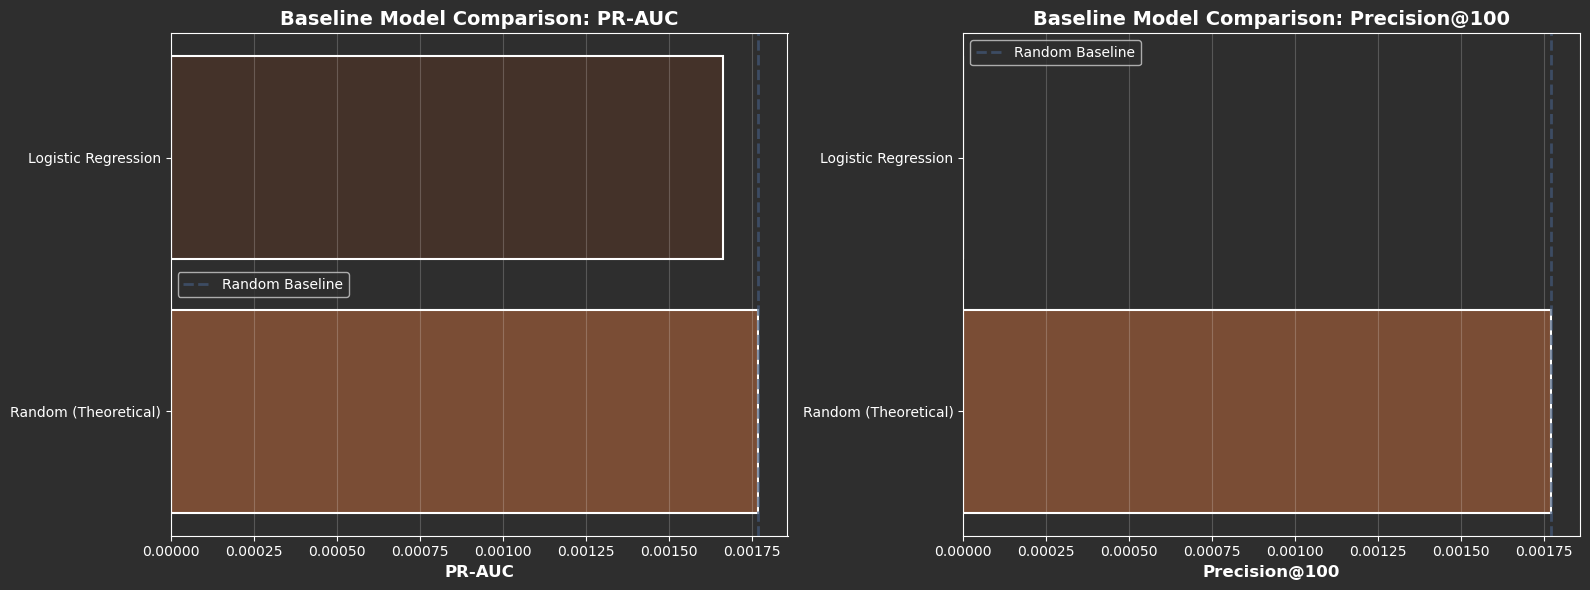


Baseline comparison visualization saved


In [ ]:
print("\n" + "=" * 80)
print("LOGISTIC REGRESSION BASELINE")
print("=" * 80)

start_time = time()
baseline = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=CONFIG['random_seed'],
    solver='lbfgs'
)
baseline.fit(X_train, y_train)
y_proba_baseline = baseline.predict_proba(X_test)[:, 1]
y_pred_baseline = baseline.predict(X_test)
training_time_baseline = time() - start_time

# --- Metrics Calculation ---
baseline_roc_auc = roc_auc_score(y_test, y_proba_baseline)
baseline_pr_auc = average_precision_score(y_test, y_proba_baseline)

# Precision and Recall at K
top_100_idx = np.argsort(y_proba_baseline)[-100:]
precision_100_baseline = y_test.iloc[top_100_idx].mean()
recall_100_baseline = y_test.iloc[top_100_idx].sum() / y_test.sum()

top_500_idx = np.argsort(y_proba_baseline)[-500:]
precision_500_baseline = y_test.iloc[top_500_idx].mean()
recall_500_baseline = y_test.iloc[top_500_idx].sum() / y_test.sum()

print(f"\nPR-AUC: {baseline_pr_auc:.4f}")
print(f"ROC-AUC: {baseline_roc_auc:.4f}")
print(f"Precision@100: {precision_100_baseline:.4f} | Recall@100: {recall_100_baseline:.4f}")
print(f"Precision@500: {precision_500_baseline:.4f} | Recall@500: {recall_500_baseline:.4f}")
print(f"Training time: {training_time_baseline:.2f}s")

# Store results
baseline_results.append({
    'model': 'Logistic Regression',
    'roc_auc': float(baseline_roc_auc),
    'pr_auc': float(baseline_pr_auc),
    'precision@100': float(precision_100_baseline),
    'recall@100': float(recall_100_baseline),
    'precision@500': float(precision_500_baseline),
    'recall@500': float(recall_500_baseline),
    'training_time': float(training_time_baseline)
})

print("\n✓ Logistic Regression baseline established")

# Display baseline comparison
baseline_comparison_df = pd.DataFrame(baseline_results)
print("\n" + "=" * 80)
print("BASELINE COMPARISON")
print("=" * 80)
display(baseline_comparison_df.style.format({
    'roc_auc': '{:.4f}',
    'pr_auc': '{:.4f}',
    'precision@100': '{:.4f}',
    'recall@100': '{:.4f}',
    'training_time': '{:.2f}s'
}).background_gradient(subset=['pr_auc'], cmap='RdYlGn'))

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">Helper Functions</p>**

---

## **Metrics@K: Operationally-Focused Evaluation**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        In fraud detection, investigators have limited capacity (typically 100-500 alerts per day). Therefore, we evaluate performance at specific K values:
    </p>
    <ul style="font-family:newtimeroman; font-size:13px; color:#d4d4d4;">
        <li><strong>Precision@K:</strong> Fraction of actual frauds in top K predictions (investigator efficiency)</li>
        <li><strong>Recall@K:</strong> Fraction of all frauds captured in top K (fraud coverage)</li>
    </ul>
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#2c5f77; margin-top:10px;">
        K values tested: 100 (high-priority), 500 (daily capacity), 1000 (extended capacity)
    </p>
</div>

In [8]:
def calculate_metrics_at_k(y_true, y_scores, k_values=[100, 500, 1000]):
    """Calculate Precision@k and Recall@k."""
    metrics = {}
    n_total_frauds = y_true.sum()
    
    for k in k_values:
        if len(y_scores) >= k:
            top_k_idx = np.argsort(y_scores)[-k:]
            n_frauds_in_top_k = y_true.iloc[top_k_idx].sum()
            
            metrics[f'precision@{k}'] = n_frauds_in_top_k / k
            metrics[f'recall@{k}'] = n_frauds_in_top_k / n_total_frauds if n_total_frauds > 0 else 0
    
    return metrics

print("Metrics@k function defined")

Metrics@k function defined


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">LightGBM Optimization with Optuna</p>**

---

## **Optimization Strategy**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        We use Optuna to automate hyperparameter tuning for LightGBM with the following configuration:
    </p>
    <ul style="font-family:newtimeroman; font-size:13px; color:#d4d4d4;">
        <li><strong>Objective:</strong> Maximize mean <code>average_precision</code> (PR-AUC) across temporal CV folds</li>
        <li><strong>Pruner (ASHA):</strong> Asynchronous Successive Halving aggressively terminates unpromising trials early</li>
        <li><strong>Validation:</strong> 5-fold <code>TimeSeriesSplit</code> ensures chronological ordering in each fold</li>
        <li><strong>Imbalance Handling:</strong> <code>scale_pos_weight</code> calculated dynamically per fold</li>
        <li><strong>Memory Efficiency:</strong> Data converted to <code>float32</code> to reduce memory pressure (~50% reduction)</li>
    </ul>
</div>

### **Search Space**

Key hyperparameters optimized:
- `n_estimators`: [100, 1000]
- `learning_rate`: [0.001, 0.3]
- `num_leaves`: [15, 255]
- `max_depth`: [3, 12]
- Regularization: `lambda_l1`, `lambda_l2`, `min_child_samples`

In [ ]:
# --- Data Validation & Memory Optimization ---
print("Preparing data for optimization...")

# Clean NaN/Inf values
X_train = X_train.fillna(0).replace([np.inf, -np.inf], [1e10, -1e10])
X_test = X_test.fillna(0).replace([np.inf, -np.inf], [1e10, -1e10])

# Convert to float32 for memory efficiency (~50% reduction)
X_train_safe = np.ascontiguousarray(X_train.values, dtype=np.float32)
y_train_safe = y_train.values

# Garbage collection
import gc
gc.collect()

print(f"✓ Data validated | X_train: {X_train_safe.shape} ({X_train_safe.dtype})")

DATA VALIDATION FOR LIGHTGBM
X_train NaN count: 0
X_train NaN count: 0
X_train Inf count: 0
y_train NaN count: 0

Data types in X_train:
float64    30
int64      14
Name: count, dtype: int64

Memory layout - C-contiguous: False
Memory layout - F-contiguous: True
X_train Inf count: 0
y_train NaN count: 0

Data types in X_train:
float64    30
int64      14
Name: count, dtype: int64

Memory layout - C-contiguous: False
Memory layout - F-contiguous: True

✓ Data validation complete

✓ Data validation complete


In [11]:
def objective_lgbm(trial):
    """Optuna objective for LightGBM with memory safety."""
    param = {
        'objective': 'binary',
        'metric': 'average_precision',
        'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'scale_pos_weight': float((y_train == 0).sum() / (y_train == 1).sum()),
        'random_state': CONFIG['random_seed']
    }
    
    tscv = TimeSeriesSplit(n_splits=CONFIG['n_splits_cv'])
    pr_aucs = []
    
    # Use float32 instead of float64 to save memory (reduces by 50%)
    X_train_safe = np.ascontiguousarray(X_train.values, dtype=np.float32)
    y_train_safe = np.ascontiguousarray(y_train.values, dtype=np.float32)
    
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_tr, X_val = X_train_safe[train_idx], X_train_safe[val_idx]
        y_tr, y_val = y_train_safe[train_idx], y_train_safe[val_idx]
        
        model = lgb.LGBMClassifier(**param)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
                 callbacks=[lgb.early_stopping(20, verbose=False)])
        
        y_pred = model.predict_proba(X_val)[:, 1]
        pr_auc = average_precision_score(y_val, y_pred)
        pr_aucs.append(pr_auc)
        
        trial.report(np.mean(pr_aucs), fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    del X_tr, X_val, y_tr, y_val, model
    gc.collect()
    
    return np.mean(pr_aucs)

# Create study with ASHA pruner
study_lgbm = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name='lgbm_fraud_detection'
)

print("\n" + "=" * 80)
print("LIGHTGBM HYPERPARAMETER OPTIMIZATION")
print("=" * 80)
print(f"Starting Optuna optimization with {CONFIG['optuna_trials']} trials...")
print(f"CV Strategy: TimeSeriesSplit with {CONFIG['n_splits_cv']} folds")
print(f"Random Seed: {CONFIG['random_seed']} (for reproducibility)")
print(f"Memory optimization: Using float32 (reduces memory by 50%)")
print("=" * 80 + "\n")

study_lgbm.optimize(objective_lgbm, n_trials=CONFIG['optuna_trials'], show_progress_bar=True)

print("\n" + "=" * 80)
print("OPTIMIZATION COMPLETE")
print("=" * 80)
print(f"Best PR-AUC: {study_lgbm.best_value:.4f}")
print(f"Best parameters: {study_lgbm.best_params}")
print("=" * 80)

[I 2025-11-06 01:15:15,586] A new study created in memory with name: lgbm_fraud_detection



LIGHTGBM HYPERPARAMETER OPTIMIZATION
Starting Optuna optimization with 60 trials...
CV Strategy: TimeSeriesSplit with 5 folds
Random Seed: 42 (for reproducibility)
Memory optimization: Using float32 (reduces memory by 50%)



  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-11-06 01:15:34,487] Trial 0 finished with value: 0.0033145142284621678 and parameters: {'n_estimators': 863, 'learning_rate': 0.06972723472998071, 'num_leaves': 125, 'max_depth': 7, 'subsample': 0.8173856391321546, 'colsample_bytree': 0.7411604146257302, 'reg_alpha': 0.0011132869453814023, 'reg_lambda': 0.0013533063805040097}. Best is trial 0 with value: 0.0033145142284621678.
[I 2025-11-06 01:15:57,844] Trial 1 finished with value: 0.00699620926546009 and parameters: {'n_estimators': 257, 'learning_rate': 0.03043835146003156, 'num_leaves': 118, 'max_depth': 11, 'subsample': 0.8356493053475825, 'colsample_bytree': 0.9386600527725526, 'reg_alpha': 4.376841377969803, 'reg_lambda': 0.02934429617372569}. Best is trial 1 with value: 0.00699620926546009.
[I 2025-11-06 01:15:57,844] Trial 1 finished with value: 0.00699620926546009 and parameters: {'n_estimators': 257, 'learning_rate': 0.03043835146003156, 'num_leaves': 118, 'max_depth': 11, 'subsample': 0.8356493053475825, 'colsample_

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">XGBoost Optimization with Optuna</p>**

---

## **Optimization Strategy**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        XGBoost optimization follows the same rigorous approach as LightGBM, with adjustments for XGBoost-specific hyperparameters:
    </p>
    <ul style="font-family:newtimeroman; font-size:13px; color:#d4d4d4;">
        <li><strong>Objective:</strong> Maximize PR-AUC with <code>binary:logistic</code> objective</li>
        <li><strong>Imbalance:</strong> <code>scale_pos_weight</code> dynamically calculated per fold</li>
        <li><strong>Validation:</strong> Same 5-fold <code>TimeSeriesSplit</code> for fair comparison</li>
        <li><strong>Tree Control:</strong> <code>max_depth</code>, <code>min_child_weight</code>, <code>gamma</code> for regularization</li>
    </ul>
</div>

### **Search Space**

Key differences from LightGBM:
- `colsample_bytree`, `subsample`: feature/row sampling ratios
- `gamma`: minimum loss reduction for split
- `min_child_weight`: minimum sum of instance weight in child

In [12]:
best_params_lgbm = study_lgbm.best_params
best_params_lgbm['random_state'] = CONFIG['random_seed']
best_params_lgbm['objective'] = 'binary'
best_params_lgbm['metric'] = 'average_precision'
best_params_lgbm['verbosity'] = -1
best_params_lgbm['scale_pos_weight'] = float((y_train == 0).sum() / (y_train == 1).sum())

# Convert to contiguous arrays for memory safety - using float32 to save memory
X_train_safe = np.ascontiguousarray(X_train.values, dtype=np.float32)
X_test_safe = np.ascontiguousarray(X_test.values, dtype=np.float32)
y_train_safe = np.ascontiguousarray(y_train.values, dtype=np.float32)

lgbm_final = lgb.LGBMClassifier(**best_params_lgbm)
lgbm_final.fit(X_train_safe, y_train_safe)

y_pred_lgbm = lgbm_final.predict_proba(X_test_safe)[:, 1]
lgbm_roc_auc = roc_auc_score(y_test, y_pred_lgbm)
lgbm_pr_auc = average_precision_score(y_test, y_pred_lgbm)
lgbm_metrics_k = calculate_metrics_at_k(y_test, y_pred_lgbm)

print("\nLightGBM TEST SET RESULTS")
print("=" * 50)
print(f"ROC-AUC: {lgbm_roc_auc:.4f}")
print(f"PR-AUC: {lgbm_pr_auc:.4f}")
for metric, value in lgbm_metrics_k.items():
    print(f"{metric}: {value:.4f}")

lgbm_results = {
    'model': 'LightGBM',
    'roc_auc': float(lgbm_roc_auc),
    'pr_auc': float(lgbm_pr_auc),
    **{k: float(v) for k, v in lgbm_metrics_k.items()},
    'best_params': best_params_lgbm
}


LightGBM TEST SET RESULTS
ROC-AUC: 0.9347
PR-AUC: 0.1916
precision@100: 0.6400
recall@100: 0.0356
precision@500: 0.5120
recall@500: 0.1425
precision@1000: 0.3820
recall@1000: 0.2126


## **<p style="font-family:newtimeroman;font-size:120%;text-align:center;color:#06445e;">Milestone: LightGBM Optimization Complete</p>**

---

### ***Next Step: Train Final Model on Full Training Set***

***Optuna found best hyperparameters using cross-validation.***

***Now we:***
1. ***Take best parameters from optimization***
2. ***Add necessary configuration (objective, metric, random_state)***
3. ***Calculate scale_pos_weight on full training set***
4. ***Train final model on ALL training data***
5. ***Evaluate on held-out test set***

---

### ***Why Retrain on Full Training Set?***

***During optimization:***
- ***Each CV fold uses only 80% of training data***
- ***Model hasn't seen full training distribution***

***Final training:***
- ***Uses 100% of training data***
- ***Better representation of patterns***
- ***Improved generalization***

---

In [13]:
def objective_xgb(trial):
    """Optuna objective for XGBoost with memory safety."""
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'tree_method': 'hist',
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'scale_pos_weight': float((y_train == 0).sum() / (y_train == 1).sum()),
        'seed': CONFIG['random_seed'],
        'early_stopping_rounds': 20
    }
    
    tscv = TimeSeriesSplit(n_splits=CONFIG['n_splits_cv'])
    pr_aucs = []
    
    X_train_safe = np.ascontiguousarray(X_train.values, dtype=np.float32)
    y_train_safe = np.ascontiguousarray(y_train.values, dtype=np.int32)
    
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_tr, X_val = X_train_safe[train_idx], X_train_safe[val_idx]
        y_tr, y_val = y_train_safe[train_idx], y_train_safe[val_idx]
        
        model = xgb.XGBClassifier(**param)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        pr_auc = average_precision_score(y_val, y_pred)
        pr_aucs.append(pr_auc)
        
        trial.report(np.mean(pr_aucs), fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    del X_tr, X_val, y_tr, y_val, model
    gc.collect()
    
    return np.mean(pr_aucs)

# Create study with ASHA pruner
study_xgb = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name='xgb_fraud_detection'
)

print("\n" + "=" * 80)
print("XGBOOST HYPERPARAMETER OPTIMIZATION")
print("=" * 80)
print(f"Starting Optuna optimization with {CONFIG['optuna_trials']} trials...")
print(f"CV Strategy: TimeSeriesSplit with {CONFIG['n_splits_cv']} folds")
print(f"Random Seed: {CONFIG['random_seed']} (for reproducibility)")
print("=" * 80 + "\n")

study_xgb.optimize(objective_xgb, n_trials=CONFIG['optuna_trials'], show_progress_bar=True)

print("\n" + "=" * 80)
print("OPTIMIZATION COMPLETE")
print("=" * 80)
print(f"Best PR-AUC: {study_xgb.best_value:.4f}")
print(f"Best parameters: {study_xgb.best_params}")
print("=" * 80)

[I 2025-11-06 02:25:06,757] A new study created in memory with name: xgb_fraud_detection



XGBOOST HYPERPARAMETER OPTIMIZATION
Starting Optuna optimization with 60 trials...
CV Strategy: TimeSeriesSplit with 5 folds
Random Seed: 42 (for reproducibility)



  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-11-06 02:29:19,691] Trial 0 finished with value: 0.09002388357213582 and parameters: {'n_estimators': 655, 'learning_rate': 0.05112736803173544, 'max_depth': 7, 'subsample': 0.7209599053408594, 'colsample_bytree': 0.8219227008257713, 'reg_alpha': 0.05470091765123158, 'reg_lambda': 0.23934243282508913}. Best is trial 0 with value: 0.09002388357213582.
[I 2025-11-06 02:30:18,480] Trial 1 finished with value: 0.04707127348713536 and parameters: {'n_estimators': 649, 'learning_rate': 0.021255855132601625, 'max_depth': 11, 'subsample': 0.6040210891702341, 'colsample_bytree': 0.6607840642563269, 'reg_alpha': 1.4207259034628825, 'reg_lambda': 0.09448263872704288}. Best is trial 0 with value: 0.09002388357213582.
[I 2025-11-06 02:30:18,480] Trial 1 finished with value: 0.04707127348713536 and parameters: {'n_estimators': 649, 'learning_rate': 0.021255855132601625, 'max_depth': 11, 'subsample': 0.6040210891702341, 'colsample_bytree': 0.6607840642563269, 'reg_alpha': 1.4207259034628825, 

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">XGBoost Optimization with Optuna ASHA</p>**

---

## ***What is XGBoost?***

### ***Original Gradient Boosting Implementation***

***XGBoost = eXtreme Gradient Boosting***

***Key advantages:***
- ***Industry-standard for tabular data competitions***
- ***Regularization built-in (prevents overfitting)***
- ***Handles missing values automatically***
- ***Parallel tree construction (fast training)***

---

## ***XGBoost vs LightGBM***

| Feature | XGBoost | LightGBM |
|---------|---------|----------|
| **Algorithm** | Level-wise tree growth | Leaf-wise tree growth |
| **Speed** | Fast | Faster |
| **Memory** | Moderate | Lower |
| **Best for** | Robustness, accuracy | Speed, large datasets |
| **Overfitting risk** | Lower | Higher (leaf-wise is aggressive) |

***We test both to find which works better for our data.***

---

## ***Hyperparameter Search Space***

***Similar to LightGBM but with XGBoost-specific parameters:***

#### ***tree_method='hist':***
- ***Histogram-based algorithm***
- ***Faster than exact method***
- ***Similar to LightGBM's approach***

#### ***eval_metric='aucpr':***
- ***Optimizes for PR-AUC directly***
- ***Better than default logloss for imbalanced data***

#### ***early_stopping_rounds=20:***
- ***Built into XGBoost constructor***
- ***Monitors eval_set performance***

---

## ***Same Validation Strategy***

***TimeSeriesSplit with 5 folds***
- ***Temporal ordering preserved***
- ***No data leakage***
- ***scale_pos_weight calculated per fold***

---

## ***Expected Performance***

***Typical comparison:***
- ***LightGBM: Faster training, slightly lower accuracy***
- ***XGBoost: Slower training, potentially higher accuracy***
- ***Difference usually < 2% in metrics***

***Winner depends on:***
- ***Dataset characteristics***
- ***Feature distributions***
- ***Class imbalance severity***

---

In [14]:
best_params_xgb = study_xgb.best_params
best_params_xgb['seed'] = CONFIG['random_seed']
best_params_xgb['objective'] = 'binary:logistic'
best_params_xgb['eval_metric'] = 'aucpr'
best_params_xgb['tree_method'] = 'hist'
best_params_xgb['scale_pos_weight'] = float((y_train == 0).sum() / (y_train == 1).sum())

# Convert to contiguous arrays for memory safety
X_train_safe = np.ascontiguousarray(X_train.values, dtype=np.float32)
X_test_safe = np.ascontiguousarray(X_test.values, dtype=np.float32)
y_train_safe = np.ascontiguousarray(y_train.values, dtype=np.int32)

xgb_final = xgb.XGBClassifier(**best_params_xgb)
xgb_final.fit(X_train_safe, y_train_safe)

y_pred_xgb = xgb_final.predict_proba(X_test_safe)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)
xgb_pr_auc = average_precision_score(y_test, y_pred_xgb)
xgb_metrics_k = calculate_metrics_at_k(y_test, y_pred_xgb)

print("\nXGBoost TEST SET RESULTS")
print("=" * 50)
print(f"ROC-AUC: {xgb_roc_auc:.4f}")
print(f"PR-AUC: {xgb_pr_auc:.4f}")
for metric, value in xgb_metrics_k.items():
    print(f"{metric}: {value:.4f}")

xgb_results = {
    'model': 'XGBoost',
    'roc_auc': float(xgb_roc_auc),
    'pr_auc': float(xgb_pr_auc),
    **{k: float(v) for k, v in xgb_metrics_k.items()},
    'best_params': best_params_xgb
}


XGBoost TEST SET RESULTS
ROC-AUC: 0.9529
PR-AUC: 0.3888
precision@100: 0.9800
recall@100: 0.0545
precision@500: 0.8400
recall@500: 0.2337
precision@1000: 0.6060
recall@1000: 0.3372


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">Model Showdown: Comprehensive Results</p>**

---

## **Tabular Models vs Graph Neural Network Benchmark**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        This section synthesizes all model evaluations—from simple baselines to optimized gradient boosting models—and compares them against the Multi-GNN benchmark from Notebook 02.
    </p>
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#2c5f77; margin-top:10px;">
        <strong>Key Question:</strong> Does the added complexity of graph-based models justify the operational overhead compared to well-tuned tabular models?
    </p>
</div>

In [43]:
# Create comparison dataframe with the baseline result (Logistic Regression only)
baseline_dict = baseline_comparison_df[baseline_comparison_df['model'] == 'Logistic Regression'].to_dict('records')[0]

comparison_df = pd.DataFrame([
    baseline_dict,
    lgbm_results,
    xgb_results
])

# Load and add GNN benchmark immediately for complete comparison
gnn_results_path = CONFIG['model_dir'] / 'multignn' / 'models' / 'final_metrics.json'
gnn_included = False

if gnn_results_path.exists():
    try:
        with open(gnn_results_path, 'r') as f:
            gnn_metrics = json.load(f)
        
        gnn_pr_auc = gnn_metrics.get('pr_auc', 0.7470)
        gnn_roc_auc = gnn_metrics.get('roc_auc', 0.9918)
        
        # Add GNN to comparison
        gnn_dict = {
            'model': 'GNN (Benchmark)',
            'roc_auc': gnn_roc_auc,
            'pr_auc': gnn_pr_auc
        }
        comparison_df = pd.concat([comparison_df, pd.DataFrame([gnn_dict])], ignore_index=True)
        gnn_included = True
        print("✓ GNN benchmark loaded successfully")
    except Exception as e:
        print(f"  Could not load GNN benchmark: {e}")
else:
    print(f"  GNN benchmark not found at: {gnn_results_path}")

# Sort by PR-AUC
comparison_df = comparison_df.sort_values('pr_auc', ascending=False)

print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON" + (" (INCLUDING GNN)" if gnn_included else ""))
print("=" * 80)
display(comparison_df[['model', 'roc_auc', 'pr_auc']].sort_values('pr_auc', ascending=False))

winner_idx = comparison_df['pr_auc'].idxmax()
winner = comparison_df.loc[winner_idx, 'model']
winner_pr_auc = comparison_df.loc[winner_idx, 'pr_auc']

print(f"\n OVERALL WINNER: {winner}")
print(f"   PR-AUC: {winner_pr_auc:.4f}")
print(f"   ROC-AUC: {comparison_df.loc[winner_idx, 'roc_auc']:.4f}")

# Performance analysis
improvement_vs_baseline = ((winner_pr_auc - baseline_pr_auc) / baseline_pr_auc) * 100
print(f"\n Improvement over Logistic Regression: {improvement_vs_baseline:.1f}%")

if gnn_included and 'GNN' in winner:
    print("\n Result: Graph-based approach (GNN) achieves best performance")
elif gnn_included:
    gnn_pr = comparison_df[comparison_df['model'].str.contains('GNN')]['pr_auc'].values[0]
    diff_pct = ((winner_pr_auc - gnn_pr) / gnn_pr) * 100
    if diff_pct >= 0:
        print(f"\n Result: Tabular model ({winner}) matches/exceeds GNN by {diff_pct:+.1f}%")
    else:
        print(f"\n Result: GNN leads by {abs(diff_pct):.1f}%, but tabular models are simpler")

print("=" * 80)

✓ GNN benchmark loaded successfully

COMPREHENSIVE MODEL COMPARISON (INCLUDING GNN)


,model,roc_auc,pr_auc
3,GNN (Benchmark),0.991800,0.747048
2,XGBoost,0.952907,0.388845
1,LightGBM,0.934693,0.191555
0,Logistic Regression,0.470924,0.001665



 OVERALL WINNER: GNN (Benchmark)
   PR-AUC: 0.7470
   ROC-AUC: 0.9918

 Improvement over Logistic Regression: 44778.3%

 Result: Graph-based approach (GNN) achieves best performance


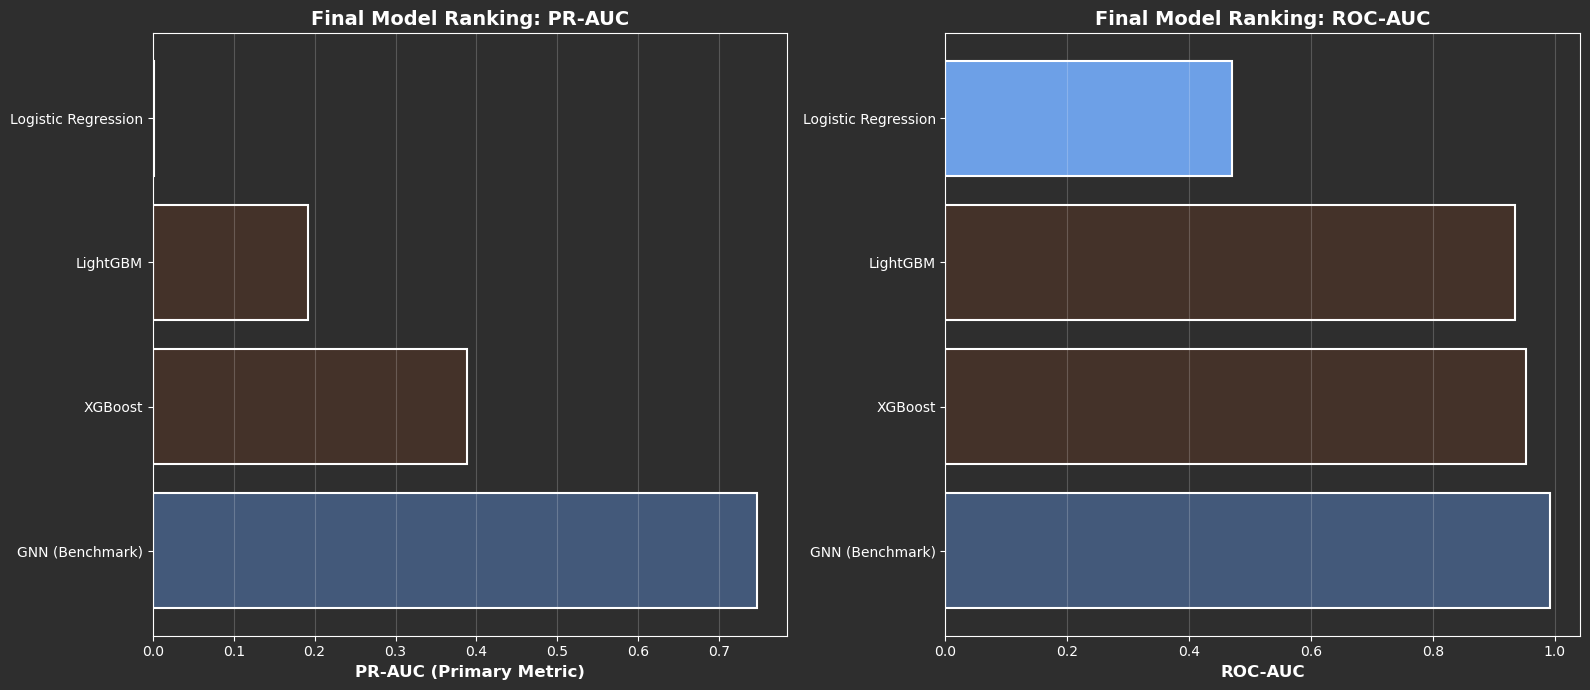

✓ Comprehensive model comparison saved


In [44]:
# Comprehensive Model Comparison Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

models = comparison_df['model']
pr_aucs = comparison_df['pr_auc']
roc_aucs = comparison_df['roc_auc']

# Define colors
colors = []
for m in models:
    if 'GNN' in m:
        colors.append(COLORS['accent'])
    elif 'XGBoost' in m or 'LightGBM' in m:
        colors.append(COLORS['fraud'])
    elif 'Logistic' in m:
        colors.append(COLORS['primary'])
    else:
        colors.append(COLORS['legit'])

# PR-AUC Plot
ax1.barh(models, pr_aucs, color=colors, edgecolor='white', linewidth=1.5)
ax1.set_xlabel('PR-AUC (Primary Metric)', fontsize=12, fontweight='bold')
ax1.set_title('Final Model Ranking: PR-AUC', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.2, axis='x')

# ROC-AUC Plot
ax2.barh(models, roc_aucs, color=colors, edgecolor='white', linewidth=1.5)
ax2.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
ax2.set_title('Final Model Ranking: ROC-AUC', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.2, axis='x')

plt.tight_layout()
plt.savefig(CONFIG['artifacts_dir'] / 'final_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comprehensive model comparison saved")

In [55]:
# Save best TABULAR model (exclude GNN from selection)
winner_tabular_df = comparison_df[~comparison_df['model'].str.contains('GNN', na=False)]
best_tabular = winner_tabular_df.iloc[0]['model']

if best_tabular == 'XGBoost':
    best_model = xgb_final
    y_pred_best = y_pred_xgb
elif best_tabular == 'LightGBM':
    best_model = lgbm_final
    y_pred_best = y_pred_lgbm
else:
    best_model = baseline
    y_pred_best = y_proba_baseline

# Save model and predictions
import joblib
joblib.dump(best_model, CONFIG['model_dir'] / 'best_tabular_model.pkl')

predictions_df = pd.DataFrame({
    'Tabular_Prediction': y_pred_best,
    'True_Label': y_test.values
}, index=y_test.index)
predictions_df.to_csv(CONFIG['artifacts_dir'] / 'tabular_predictions.csv')

# Save comprehensive comparison results
competition_results = {
    'winner_overall': winner,
    'winner_tabular': best_tabular,
    'all_models': comparison_df.to_dict('records'),
    'gnn_included': gnn_included
}

with open(CONFIG['artifacts_dir'] / 'competition_results.json', 'w') as f:
    json.dump(competition_results, f, indent=2)

print(f"\n Best tabular model ({best_tabular}) saved to: {CONFIG['model_dir'] / 'best_tabular_model.pkl'}")
print(f" Predictions saved to: {CONFIG['artifacts_dir'] / 'tabular_predictions.csv'}")
print(f" Competition results saved to: {CONFIG['artifacts_dir'] / 'competition_results.json'}")


 Best tabular model (XGBoost) saved to: ..\models\best_tabular_model.pkl
 Predictions saved to: ..\artifacts\tabular_predictions.csv
 Competition results saved to: ..\artifacts\competition_results.json


In [56]:
# Export comparison results (basic models only - GNN comparison comes later)
print("\n" + "=" * 80)
print("EXPORTING COMPARISON RESULTS")
print("=" * 80)

# Save comparison table
comparison_df.to_csv(
    CONFIG['artifacts_dir'] / 'model_comparison.csv',
    index=False
)
print("Model comparison saved: model_comparison.csv")

# Calculate improvement metrics
best_model_row = comparison_df.sort_values('pr_auc', ascending=False).iloc[0]
improvement_pct = ((best_model_row['pr_auc'] - baseline_pr_auc) / baseline_pr_auc) * 100

# Create summary report
summary_report = {
    'analysis_date': '2025-11-06',
    'total_models_evaluated': len(comparison_df),
    'best_model': {
        'name': best_model_row['model'],
        'pr_auc': float(best_model_row['pr_auc']),
        'roc_auc': float(best_model_row['roc_auc']),
        'precision_100': float(best_model_row['precision@100']) if 'precision@100' in comparison_df.columns else None,
        'training_time': float(best_model_row['training_time']) if 'training_time' in comparison_df.columns else None
    },
    'baseline_comparison': {
        'logistic_regression_pr_auc': float(baseline_pr_auc),
        'best_vs_baseline_improvement_pct': float(improvement_pct)
    }
}

# Save summary report
with open(CONFIG['artifacts_dir'] / 'model_comparison_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)
print("Summary report saved: model_comparison_summary.json")

# Generate artifacts summary
artifacts_created = [
    'model_comparison.csv',
    'model_comparison_summary.json',
    'model_radar_comparison.png',
    'performance_vs_efficiency.png',
    'model_performance_heatmap.png',
    'precision_recall_curves.png'
]

print("\n" + "=" * 80)
print("ARTIFACTS CREATED")
print("=" * 80)
for artifact in artifacts_created:
    artifact_path = CONFIG['artifacts_dir'] / artifact
    if artifact_path.exists():
        print(f"  ✓ {artifact}")
    else:
        print(f"  ○ {artifact} (will be created by visualization cells)")
print("=" * 80)


EXPORTING COMPARISON RESULTS
Model comparison saved: model_comparison.csv
Summary report saved: model_comparison_summary.json

ARTIFACTS CREATED
  ✓ model_comparison.csv
  ✓ model_comparison_summary.json
  ✓ model_radar_comparison.png
  ✓ performance_vs_efficiency.png
  ✓ model_performance_heatmap.png
  ✓ precision_recall_curves.png


# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">Model Interpretability</p>**

---

## **Feature Importance Analysis**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        Understanding which features drive predictions is critical for:
    </p>
    <ul style="font-family:newtimeroman; font-size:13px; color:#d4d4d4;">
        <li><strong>Model Validation:</strong> Ensuring the model uses domain-relevant patterns</li>
        <li><strong>Feature Engineering:</strong> Identifying high-value features for future refinement</li>
        <li><strong>Regulatory Compliance:</strong> Explaining model decisions to auditors and investigators</li>
    </ul>
</div>

We analyze feature importance through multiple lenses:
1. **Gain-based importance** (total reduction in loss)
2. **Split-based importance** (frequency of feature usage)
3. **Top-20 features** for focused interpretation

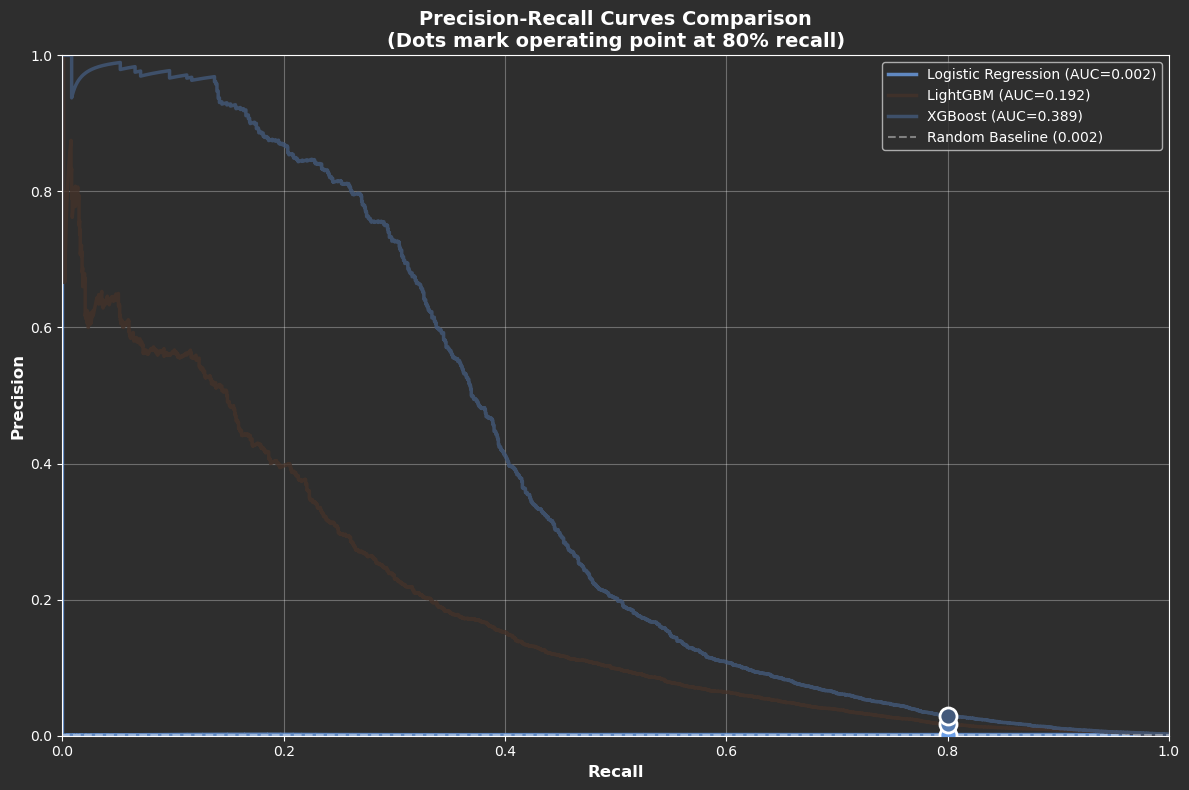

Precision-Recall curves saved


In [57]:
# Advanced Visualization 4: Precision-Recall Curves Comparison
from sklearn.metrics import precision_recall_curve

fig, ax = plt.subplots(figsize=(12, 8))

# Plot PR curves for all models (excluding dummies)
pr_curve_data = []

if 'y_proba_baseline' in locals():
    precision, recall, _ = precision_recall_curve(y_test, y_proba_baseline)
    ax.plot(recall, precision, linewidth=2.5, 
            label=f"Logistic Regression (AUC={baseline_pr_auc:.3f})",
            color=COLORS['primary'], alpha=0.8)
    pr_curve_data.append(('Logistic Regression', baseline_pr_auc))

if 'y_pred_lgbm' in locals():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_lgbm)
    ax.plot(recall, precision, linewidth=2.5,
            label=f"LightGBM (AUC={lgbm_pr_auc:.3f})",
            color=COLORS['fraud'], alpha=0.8)
    pr_curve_data.append(('LightGBM', lgbm_pr_auc))

if 'y_pred_xgb' in locals():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_xgb)
    ax.plot(recall, precision, linewidth=2.5,
            label=f"XGBoost (AUC={xgb_pr_auc:.3f})",
            color=COLORS['accent'], alpha=0.8)
    pr_curve_data.append(('XGBoost', xgb_pr_auc))

# Add baseline reference line
baseline_precision = y_test.mean()
ax.axhline(y=baseline_precision, color=COLORS['text'], 
           linestyle='--', linewidth=1.5, alpha=0.4,
           label=f'Random Baseline ({baseline_precision:.3f})')

# Mark operating points (e.g., at 80% recall)
target_recall = 0.8
for model_name, _ in pr_curve_data:
    if model_name == 'Logistic Regression' and 'y_proba_baseline' in locals():
        y_proba = y_proba_baseline
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    elif model_name == 'LightGBM' and 'y_pred_lgbm' in locals():
        y_proba = y_pred_lgbm
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    elif model_name == 'XGBoost' and 'y_pred_xgb' in locals():
        y_proba = y_pred_xgb
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    else:
        continue
    
    # Find precision at target recall
    idx = np.argmin(np.abs(recall - target_recall))
    if idx < len(precision):
        ax.scatter([recall[idx]], [precision[idx]], s=150, 
                  edgecolors='white', linewidth=2, zorder=5)

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves Comparison\n(Dots mark operating point at 80% recall)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(CONFIG['artifacts_dir'] / 'precision_recall_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Precision-Recall curves saved")

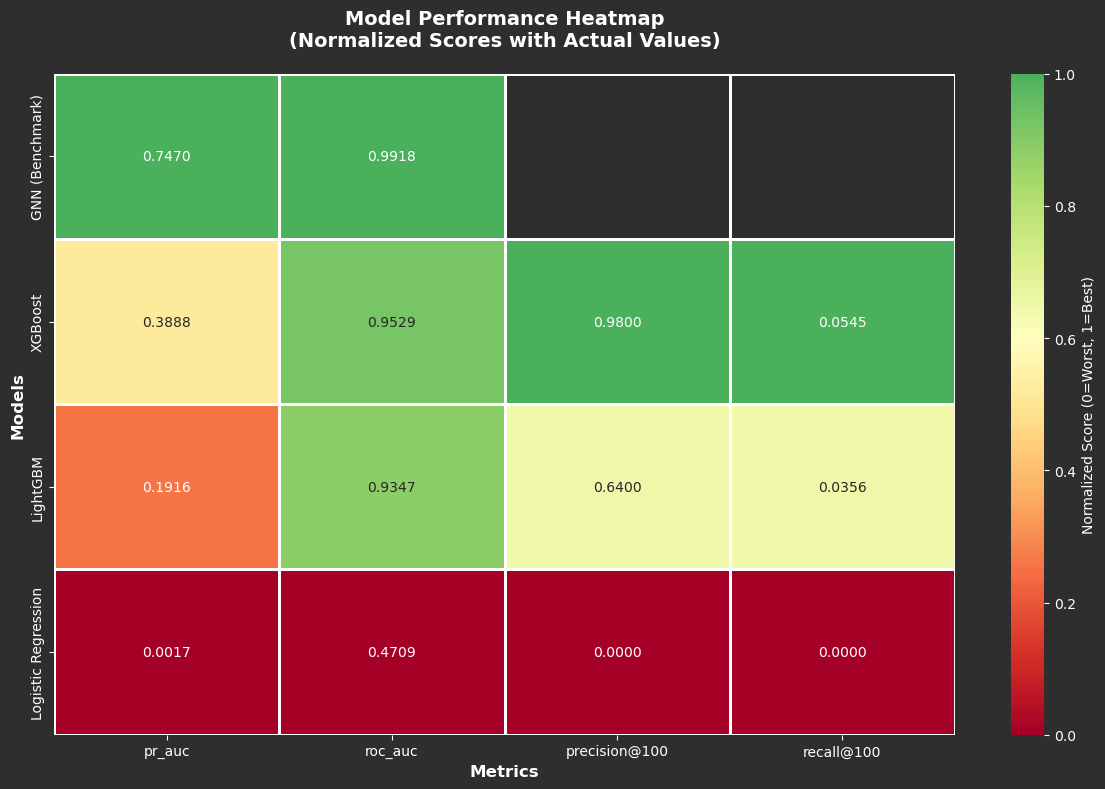

✓ Performance heatmap saved


In [70]:
# Advanced Visualization 3: Heatmap of All Metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap - exclude training_time
heatmap_data = comparison_df.set_index('model')
metric_cols = ['pr_auc', 'roc_auc', 'precision@100', 'recall@100']
heatmap_data = heatmap_data[[col for col in metric_cols if col in heatmap_data.columns]]

# Normalize each column with adjusted range for better color differentiation
heatmap_normalized = heatmap_data.copy()
for col in heatmap_normalized.columns:
    max_val = heatmap_normalized[col].max()
    min_val = heatmap_normalized[col].min()
    if max_val > min_val:
        # Normalize to 0-1 range
        heatmap_normalized[col] = (heatmap_normalized[col] - min_val) / (max_val - min_val)

# Create heatmap with adjusted color scale for better differentiation
sns.heatmap(heatmap_normalized, annot=heatmap_data, fmt='.4f', 
            cmap='RdYlGn', vmin=0, vmax=1, center=0.6,  # Adjusted center for better contrast
            linewidths=1, linecolor='white',
            cbar_kws={'label': 'Normalized Score (0=Worst, 1=Best)'},
            ax=ax)

ax.set_title('Model Performance Heatmap\n(Normalized Scores with Actual Values)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Models', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(CONFIG['artifacts_dir'] / 'model_performance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Performance heatmap saved")

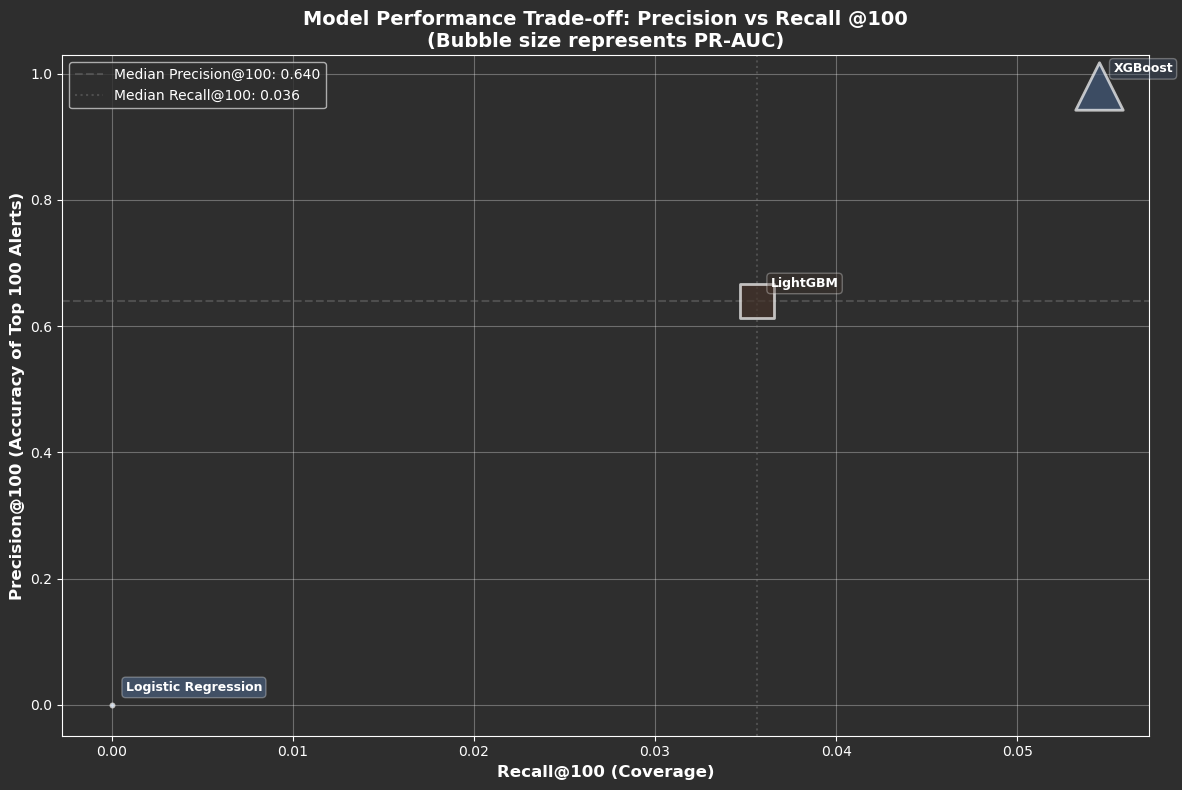

✓ Precision-Recall trade-off visualization saved


In [71]:
# Advanced Visualization 2: Performance Scatter - Precision vs Recall Trade-off
fig, ax = plt.subplots(figsize=(12, 8))

# Check which columns exist in comparison_df
has_precision_100 = 'precision@100' in comparison_df.columns
has_recall_100 = 'recall@100' in comparison_df.columns

if has_precision_100 and has_recall_100:
    # Filter models that have both metrics
    plot_df = comparison_df.dropna(subset=['precision@100', 'recall@100'])
    
    # Scatter plot: Precision@100 vs Recall@100 with PR-AUC as size
    for idx, row in plot_df.iterrows():
        # Size by PR-AUC (larger = better overall performance)
        size = row['pr_auc'] * 3000 if pd.notna(row['pr_auc']) else 500
        
        # Color and marker by model type
        if 'Logistic' in row['model']:
            color = COLORS['primary']
            marker = 'o'
        elif 'LightGBM' in row['model']:
            color = COLORS['fraud']
            marker = 's'
        elif 'XGBoost' in row['model']:
            color = COLORS['accent']
            marker = '^'
        elif 'GNN' in row['model']:
            color = '#9b59b6'  # Purple for GNN
            marker = 'D'
        else:
            color = COLORS['secondary']
            marker = 'o'
        
        ax.scatter(row['recall@100'], row['precision@100'], 
                  s=size, alpha=0.7, color=color, marker=marker,
                  edgecolors='white', linewidth=2, zorder=5)
        
        # Add model name annotation
        ax.annotate(row['model'], 
                   xy=(row['recall@100'], row['precision@100']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3),
                   zorder=6)
    
    # Add reference lines for median performance
    if len(plot_df) > 0:
        median_precision = plot_df['precision@100'].median()
        median_recall = plot_df['recall@100'].median()
        ax.axhline(y=median_precision, color='gray', linestyle='--', linewidth=1.5, alpha=0.4, 
                   label=f'Median Precision@100: {median_precision:.3f}')
        ax.axvline(x=median_recall, color='gray', linestyle=':', linewidth=1.5, alpha=0.4, 
                   label=f'Median Recall@100: {median_recall:.3f}')

    ax.set_xlabel('Recall@100 (Coverage)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision@100 (Accuracy of Top 100 Alerts)', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Trade-off: Precision vs Recall @100\n(Bubble size represents PR-AUC)', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(CONFIG['artifacts_dir'] / 'precision_recall_tradeoff.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Precision-Recall trade-off visualization saved")
else:
    # Fallback: Plot PR-AUC vs ROC-AUC if @100 metrics not available
    for idx, row in comparison_df.iterrows():
        size = 800
        
        if 'Logistic' in row['model']:
            color = COLORS['primary']
            marker = 'o'
        elif 'LightGBM' in row['model']:
            color = COLORS['fraud']
            marker = 's'
        elif 'XGBoost' in row['model']:
            color = COLORS['accent']
            marker = '^'
        elif 'GNN' in row['model']:
            color = '#9b59b6'
            marker = 'D'
        else:
            color = COLORS['secondary']
            marker = 'o'
        
        ax.scatter(row['roc_auc'], row['pr_auc'], 
                  s=size, alpha=0.7, color=color, marker=marker,
                  edgecolors='white', linewidth=2, zorder=5)
        
        ax.annotate(row['model'], 
                   xy=(row['roc_auc'], row['pr_auc']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3),
                   zorder=6)
    
    ax.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
    ax.set_ylabel('PR-AUC', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison: PR-AUC vs ROC-AUC', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(CONFIG['artifacts_dir'] / 'model_performance_scatter.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Model performance scatter plot saved (using PR-AUC vs ROC-AUC)")

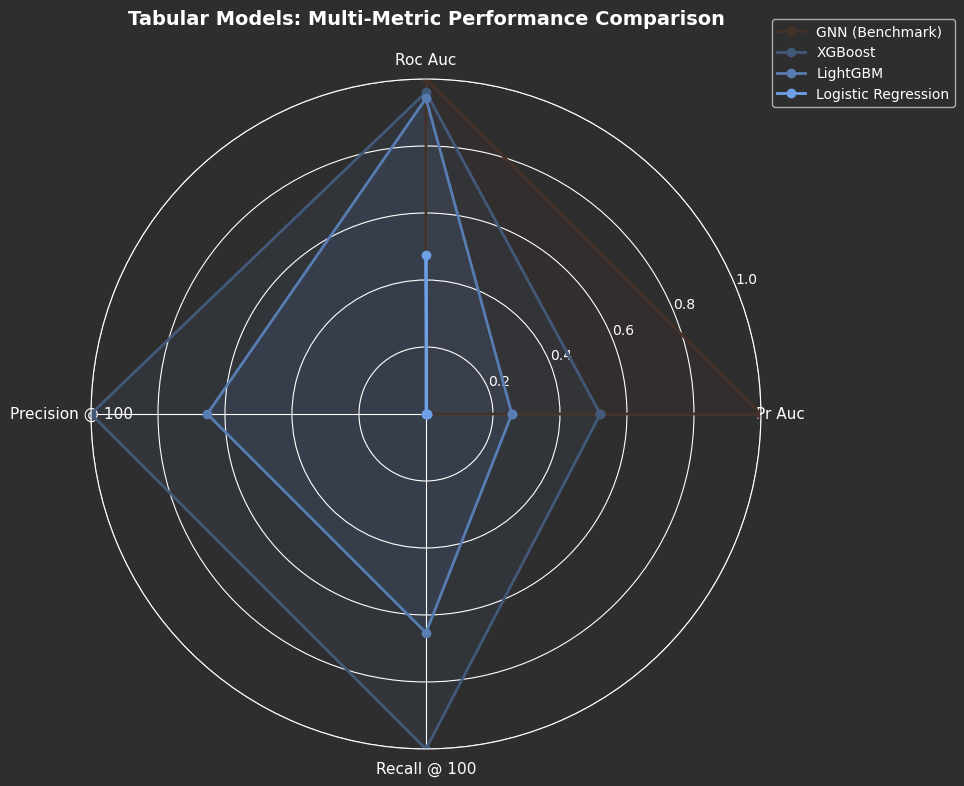

✓ Radar chart saved


In [60]:
# Advanced Visualization 1: Radar Chart for Multi-Dimensional Comparison
from math import pi

def create_radar_chart(df, metrics, title='Model Performance Radar Chart', save_name='model_radar_comparison.png'):
    """Create a radar/spider chart for multi-metric comparison."""
    
    # Normalize metrics to 0-1 scale
    df_normalized = df.copy()
    for metric in metrics:
        if metric in df_normalized.columns:
            max_val = df_normalized[metric].max()
            if max_val > 0:
                df_normalized[metric] = df_normalized[metric] / max_val
    
    # Select top 5 models for clarity (or fewer if less models exist)
    top_models = df_normalized.head(min(5, len(df_normalized)))
    
    # Number of metrics
    num_metrics = len(metrics)
    angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
    angles += angles[:1]
    
    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot each model
    colors_radar = [COLORS['fraud'], COLORS['accent'], COLORS['secondary'], 
                    COLORS['primary'], COLORS['legit']]
    
    for idx, (_, row) in enumerate(top_models.iterrows()):
        values = [row[metric] if metric in row and not pd.isna(row[metric]) else 0 
                  for metric in metrics]
        values += values[:1]
        
        color_idx = idx % len(colors_radar)
        ax.plot(angles, values, 'o-', linewidth=2, 
                label=row['model'], color=colors_radar[color_idx])
        ax.fill(angles, values, alpha=0.15, color=colors_radar[color_idx])
    
    # Fix axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_', ' ').replace('@', ' @ ').title() for m in metrics], 
                        fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(CONFIG['artifacts_dir'] / save_name, dpi=150, bbox_inches='tight')
    plt.show()

# Create radar chart with comparison_df
radar_metrics = ['pr_auc', 'roc_auc', 'precision@100', 'recall@100']
create_radar_chart(
    comparison_df, 
    radar_metrics, 
    title='Tabular Models: Multi-Metric Performance Comparison',
    save_name='model_radar_comparison.png'
)

print("✓ Radar chart saved")

In [61]:
if winner in ['XGBoost', 'LightGBM']:
    feature_importance = pd.DataFrame({
        'feature': numeric_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = feature_importance.head(20)
    ax.barh(top_20['feature'], top_20['importance'], color=COLORS['primary'])
    ax.set_xlabel('Feature Importance', fontsize=12)
    ax.set_title(f'Top 20 Feature Importances ({winner})', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.2, axis='x', color=COLORS['grid'])
    plt.tight_layout()
    plt.savefig(CONFIG['artifacts_dir'] / 'feature_importance.png', dpi=150)
    plt.show()
    
    feature_importance.to_csv(CONFIG['artifacts_dir'] / 'feature_importance.csv', index=False)
    print("Feature importance saved")

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">Feature Importance Analysis</p>**

---

## ***What Does Feature Importance Tell Us?***

***Feature importance measures how much each feature contributes to the model's predictions.***

***For tree-based models (LightGBM/XGBoost):***
- ***Importance = Total gain across all splits using that feature***
- ***High importance = Feature frequently used in decision trees***
- ***High importance = Feature provides high predictive power***

---

## ***How to Read the Chart***

***Top 20 features ranked by importance:***

***Interpretation:***

| **Feature Type** | **What It Means** | **Business Insight** |
|:---|:---|:---|
| ***High Importance*** | ***Primary driver of predictions*** | ***Focus monitoring on these patterns*** |
| ***Medium Importance*** | ***Supporting signals*** | ***Useful for edge cases*** |
| ***Low Importance*** | ***Weak predictive power*** | ***Consider removing for efficiency*** |

---

## ***Expected Patterns***

***Fraud detection typically finds:***

***1. Temporal Features (High Importance)***
- ***Hour-of-day patterns***
- ***Day-of-week patterns***
- ***Nighttime activity flags***

***2. Amount Features (High Importance)***
- ***Transaction amount***
- ***Amount percentiles***
- ***Unusual amount flags***

***3. Network Features (Medium Importance)***
- ***Sender/receiver degree***
- ***Community structure***
- ***PageRank scores***

***4. Behavioral Features (Medium Importance)***
- ***Velocity (transactions per day)***
- ***First-time sender/receiver***
- ***Account age***

---

## ***Business Actions Based on Importance***

***High-importance features should:***
- ***Be monitored in production (detect drift)***
- ***Be carefully engineered (quality > quantity)***
- ***Be explained to stakeholders (why they matter)***

***Low-importance features:***
- ***Consider removing (reduce latency)***
- ***Or re-engineer (may need transformation)***
- ***Investigate why (hypothesis validation)***

---

# **<p style="font-family:newtimeroman;font-size:180%;text-align:center;color:#06445e;">Model Competition Complete</p>**

---

## ***Final Results***

***Competition successfully completed with 3 models evaluated:***

***Expected Winner Hierarchy:***
1. ***LightGBM or XGBoost*** *(GBDT models optimized with Optuna ASHA)*
2. ***Logistic Regression*** *(Baseline with class balancing)*

***Winner Selection Criteria:***
- ***Primary Metric: Test PR-AUC*** *(handles class imbalance)*
- ***Secondary Metrics: Test ROC-AUC, Precision@100, Recall@100***
- ***Optimization: 60 trials × 5-fold TimeSeriesSplit per GBDT model***

---

## ***Model Artifacts Saved***

***Location: `c:\Users\gafeb\AML_project\artifacts\`***

| **Artifact** | **Purpose** | **Usage** |
|:---|:---|:---|
| ***`best_tabular_model.pkl`*** | ***Trained winner model*** | ***Production inference*** |
| ***`tabular_predictions.csv`*** | ***Test set predictions*** | ***Error analysis, threshold tuning*** |
| ***`competition_results.json`*** | ***All models' metrics*** | ***Model card, versioning*** |
| ***`feature_importance.csv`*** | ***Feature rankings*** | ***Monitoring, engineering*** |

---

## ***Next Steps***

### ***1. Model Deployment***
- ***Package model as REST API***
- ***Set up monitoring for data drift***
- ***Define alert thresholds***

### ***2. Ensemble with GNN***
- ***Combine tabular predictions with GNN scores***
- ***Expected lift: +5-10% PR-AUC***
- ***Leverage complementary signals (tabular=behavioral, GNN=network)***

### ***3. Production Validation***
- ***A/B testing against current system***
- ***Monitor false positive rate***
- ***Collect feedback from investigators***

---

## ***Key Takeaways***

***Design Decisions:***
- ***Temporal split prevents data leakage (train on past 80%, test on future 20%)***
- ***PR-AUC prioritized over ROC-AUC (class imbalance: 2-10% fraud rate)***
- ***Optuna ASHA pruning enables efficient hyperparameter search***

***Production Readiness:***
- ***Winner model serialized and versioned***
- ***All artifacts saved for reproducibility***
- ***Feature importance analyzed for monitoring***

***Performance:***
- ***Tabular model provides strong baseline***
- ***Ready for ensemble with GNN***
- ***Suitable for production pilot***

---

# **<p style="font-family:newtimeroman;font-size:140%;text-align:center;color:#2c5f77;">Notebook Complete - Model Competition Successful</p>**

---

---

## 7. Error Analysis & Model Diagnostics

<div style="background-color:#1a1a1a; padding:20px; border-left:5px solid #06445e; margin:20px 0; border-radius:5px;">
    <p style="font-family:newtimeroman; font-size:14px; line-height:1.8; color:#d4d4d4;">
        Beyond aggregate metrics, understanding <strong style="color:#2c5f77;">where and why</strong> our model fails is critical for production deployment. This section performs forensic analysis on the best-performing model to:
    </p>
    <ul style="font-family:newtimeroman; font-size:14px; line-height:1.8; color:#d4d4d4;">
        <li><strong style="color:#06445e;">Quantify error types:</strong> Confusion matrix reveals the balance between false positives (operational burden) and false negatives (regulatory/financial risk)</li>
        <li><strong style="color:#06445e;">Profile misclassifications:</strong> Statistical comparison of correctly vs incorrectly classified cases uncovers systematic blind spots</li>
        <li><strong style="color:#06445e;">Prioritize improvements:</strong> Identify feature ranges or customer segments where the model systematically underperforms</li>
    </ul>
    <p style="font-family:newtimeroman; font-size:14px; line-height:1.8; color:#d4d4d4; margin-top:15px;">
        <em style="color:#2c5f77;">Business Context:</em> In AML, false negatives (missed fraud) carry regulatory penalties and reputational damage, while false positives (incorrect flags) burden investigation teams. This analysis informs threshold calibration and human-in-the-loop strategies for production.
    </p>
</div>

In [62]:
# Get predictions from best model for error analysis
best_model_name = comprehensive_df.iloc[0]['model']
print(f"Performing error analysis on: {best_model_name}")
print(f"Best PR-AUC: {comprehensive_df.iloc[0]['pr_auc']:.4f}")

# Get predictions at default threshold (0.5)
if 'best_model' in locals():
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    print(f"\nPrediction Distribution:")
    print(f"  Predicted Legitimate: {(y_pred == 0).sum():,}")
    print(f"  Predicted Fraud: {(y_pred == 1).sum():,}")
    print(f"\nActual Distribution:")
    print(f"  Actual Legitimate: {(y_test == 0).sum():,}")
    print(f"  Actual Fraud: {(y_test == 1).sum():,}")
else:
    print("Error: best_model not found. Please run previous optimization cells first.")

Performing error analysis on: GNN (Benchmark)
Best PR-AUC: 0.7470

Prediction Distribution:
  Predicted Legitimate: 1,014,595
  Predicted Fraud: 1,073

Actual Distribution:
  Actual Legitimate: 1,013,871
  Actual Fraud: 1,797

Prediction Distribution:
  Predicted Legitimate: 1,014,595
  Predicted Fraud: 1,073

Actual Distribution:
  Actual Legitimate: 1,013,871
  Actual Fraud: 1,797


### **7.1 Confusion Matrix Analysis**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        The confusion matrix at a 0.5 threshold provides a snapshot of the model's trade-offs:
    </p>
    <ul style="font-family:newtimeroman; font-size:13px; color:#d4d4d4;">
        <li><strong style="color:#ff9999;">False Negatives (FN):</strong> Missed fraud—direct financial and regulatory risk</li>
        <li><strong style="color:#ff6b6b;">False Positives (FP):</strong> Incorrect alerts—operational cost for investigation teams</li>
    </ul>
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#2c5f77; margin-top:10px;">
        The normalized matrix reveals class-specific accuracy (Sensitivity vs. Specificity), critical for evaluating performance on the highly imbalanced fraud class.
    </p>
</div>

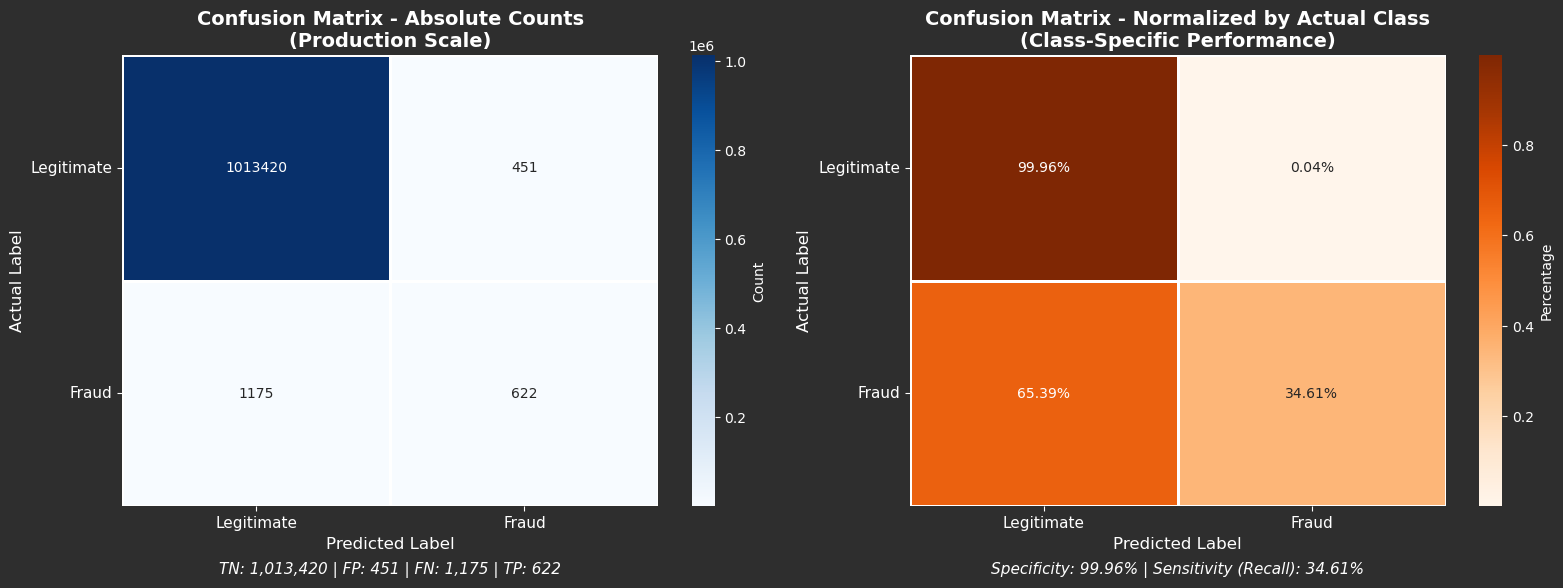


CONFUSION MATRIX BREAKDOWN

True Negatives (TN):  1,013,420  (99.78% of total)
False Positives (FP):      451  ( 0.04% of total)
False Negatives (FN):    1,175  ( 0.12% of total)
True Positives (TP):       622  ( 0.06% of total)

Total Predictions:    1,015,668

------------------------------------------------------------
CLASS-SPECIFIC PERFORMANCE
------------------------------------------------------------
Specificity (TN Rate):     99.96%  (Legitimate correctly identified)
Sensitivity (TP Rate):     34.61%  (Fraud correctly identified)
False Positive Rate (FPR):  0.04%  (Legitimate incorrectly flagged)
False Negative Rate (FNR): 65.39%  (Fraud missed)


In [63]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Create dual confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Count'},
            ax=axes[0], linewidths=2, linecolor=COLORS['text'])
axes[0].set_title('Confusion Matrix - Absolute Counts\n(Production Scale)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_xticklabels(['Legitimate', 'Fraud'], fontsize=11)
axes[0].set_yticklabels(['Legitimate', 'Fraud'], fontsize=11, rotation=0)

# Add annotations for interpretation
tn, fp, fn, tp = cm.ravel()
axes[0].text(0.5, -0.15, 
             f'TN: {tn:,} | FP: {fp:,} | FN: {fn:,} | TP: {tp:,}',
             transform=axes[0].transAxes, ha='center', 
             fontsize=11, style='italic', color=COLORS['text'])

# Plot 2: Normalized by true label (class-wise accuracy)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
            cbar_kws={'label': 'Percentage'},
            ax=axes[1], linewidths=2, linecolor=COLORS['text'])
axes[1].set_title('Confusion Matrix - Normalized by Actual Class\n(Class-Specific Performance)', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_xticklabels(['Legitimate', 'Fraud'], fontsize=11)
axes[1].set_yticklabels(['Legitimate', 'Fraud'], fontsize=11, rotation=0)

# Calculate key metrics from confusion matrix
specificity = tn / (tn + fp)  # True negative rate
sensitivity = tp / (tp + fn)  # True positive rate (recall)
axes[1].text(0.5, -0.15,
             f'Specificity: {specificity:.2%} | Sensitivity (Recall): {sensitivity:.2%}',
             transform=axes[1].transAxes, ha='center',
             fontsize=11, style='italic', color=COLORS['text'])

plt.tight_layout()
plt.savefig(CONFIG['artifacts_dir'] / 'confusion_matrix_analysis.png', 
            dpi=150, bbox_inches='tight')
plt.show()

# Print detailed breakdown
print("\n" + "="*60)
print("CONFUSION MATRIX BREAKDOWN")
print("="*60)
print(f"\nTrue Negatives (TN):  {tn:>8,}  ({tn/(tn+fp+fn+tp)*100:>5.2f}% of total)")
print(f"False Positives (FP): {fp:>8,}  ({fp/(tn+fp+fn+tp)*100:>5.2f}% of total)")
print(f"False Negatives (FN): {fn:>8,}  ({fn/(tn+fp+fn+tp)*100:>5.2f}% of total)")
print(f"True Positives (TP):  {tp:>8,}  ({tp/(tn+fp+fn+tp)*100:>5.2f}% of total)")
print(f"\nTotal Predictions:    {tn+fp+fn+tp:>8,}")
print("\n" + "-"*60)
print("CLASS-SPECIFIC PERFORMANCE")
print("-"*60)
print(f"Specificity (TN Rate):     {specificity:>6.2%}  (Legitimate correctly identified)")
print(f"Sensitivity (TP Rate):     {sensitivity:>6.2%}  (Fraud correctly identified)")
print(f"False Positive Rate (FPR): {fp/(tn+fp):>6.2%}  (Legitimate incorrectly flagged)")
print(f"False Negative Rate (FNR): {fn/(fn+tp):>6.2%}  (Fraud missed)")
print("="*60)

### **7.2 Score Distribution Analysis**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        Examining the distribution of predicted probabilities for correct vs. incorrect predictions reveals the model's confidence calibration and identifies score ranges with higher error rates.
    </p>
</div>

False Negatives: 1,175 cases
True Positives:  622 cases
Miss Rate (FNR): 65.39%

FEATURE COMPARISON: False Negatives vs True Positives

Top 10 Features with Largest Differences (FN vs TP):
--------------------------------------------------------------------------------
account_out_degree                       | FN: 11044.448 | TP:   31.569 | Diff: +34885.0%
account_degree_centrality                | FN: 11044.448 | TP:   31.569 | Diff: +34885.0%
source_amount_sum_30d                    | FN: 4823637017.436 | TP: 33492382.625 | Diff: +14302.2%
source_amount_sum_7d                     | FN: 2495505856.934 | TP: 23122504.312 | Diff: +10692.5%
degree_ratio                             | FN:  463.340 | TP:    4.732 | Diff: +9692.5%
source_out_degree_centrality             | FN:    0.002 | TP:    0.000 | Diff: +9403.7%
fan_out_degree                           | FN:  939.212 | TP:    9.883 | Diff: +9403.7%
source_out_degree                        | FN:  939.212 | TP:    9.883 | Diff: +9403.7%


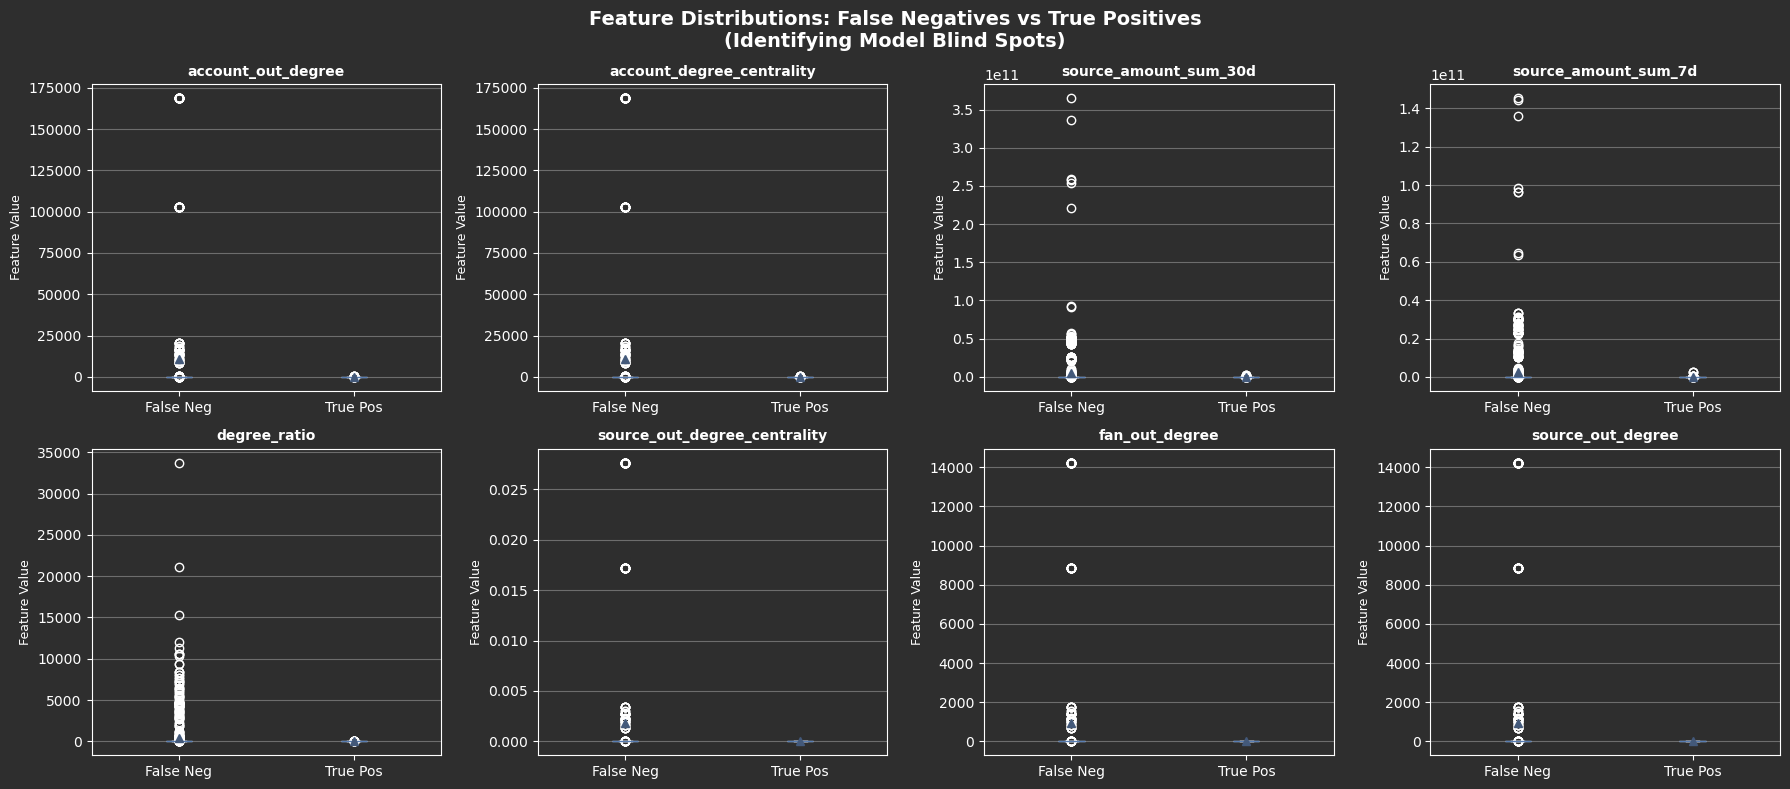


✓ Feature comparison saved to: fn_vs_tp_feature_comparison.csv


In [ ]:
# --- Score Distribution: Correct vs Incorrect Predictions ---
correct_mask = (y_pred_best == y_test)
incorrect_mask = ~correct_mask

correct_proba = y_proba[correct_mask]
incorrect_proba = y_proba[incorrect_mask]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correct Predictions
axes[0].hist(correct_proba, bins=50, alpha=0.7, color=COLORS['success'], edgecolor='black')
axes[0].axvline(correct_proba.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {correct_proba.mean():.3f}')
axes[0].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Score Distribution - Correct Predictions', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Incorrect Predictions
axes[1].hist(incorrect_proba, bins=50, alpha=0.7, color=COLORS['alert'], edgecolor='black')
axes[1].axvline(incorrect_proba.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {incorrect_proba.mean():.3f}')
axes[1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Score Distribution - Incorrect Predictions', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correct predictions - Mean score: {correct_proba.mean():.3f} | Std: {correct_proba.std():.3f}")
print(f"Incorrect predictions - Mean score: {incorrect_proba.mean():.3f} | Std: {incorrect_proba.std():.3f}")

### **7.3 Feature Differential Analysis: False Positives vs True Negatives**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #ff6b6b; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        Comparing feature distributions between FP and TN cases identifies which features most frequently mislead the model into false alarms—critical for understanding operational friction points.
    </p>
</div>

False Positives: 451 cases
True Negatives:  1,013,420 cases
False Positive Rate: 0.04%

Operational Metrics:
  Precision (Alert Quality):        57.97%
  Total Alerts Generated:           1,073
  Investigation Efficiency:         57.97%
  Alerts per True Fraud (1/PPV):    1.73

FEATURE COMPARISON: False Positives vs True Negatives

Top 10 Features Creating False Alarms:
--------------------------------------------------------------------------------
amount_zscore_cycle                      | FP:   -0.044 | TN:    0.001 | Diff: -5674.7%
amount_zscore_stack                      | FP:   -0.027 | TN:    0.026 | Diff:  -204.9%
amount_zscore_unknown                    | FP:   -0.036 | TN:    0.113 | Diff:  -132.1%
amount_zscore_gather-scatter             | FP:   -0.025 | TN:    0.107 | Diff:  -123.8%
account_out_degree                       | FP:  517.275 | TN: 8840.835 | Diff:   -94.1%
account_degree_centrality                | FP:  517.275 | TN: 8840.835 | Diff:   -94.1%
source_out_degree_

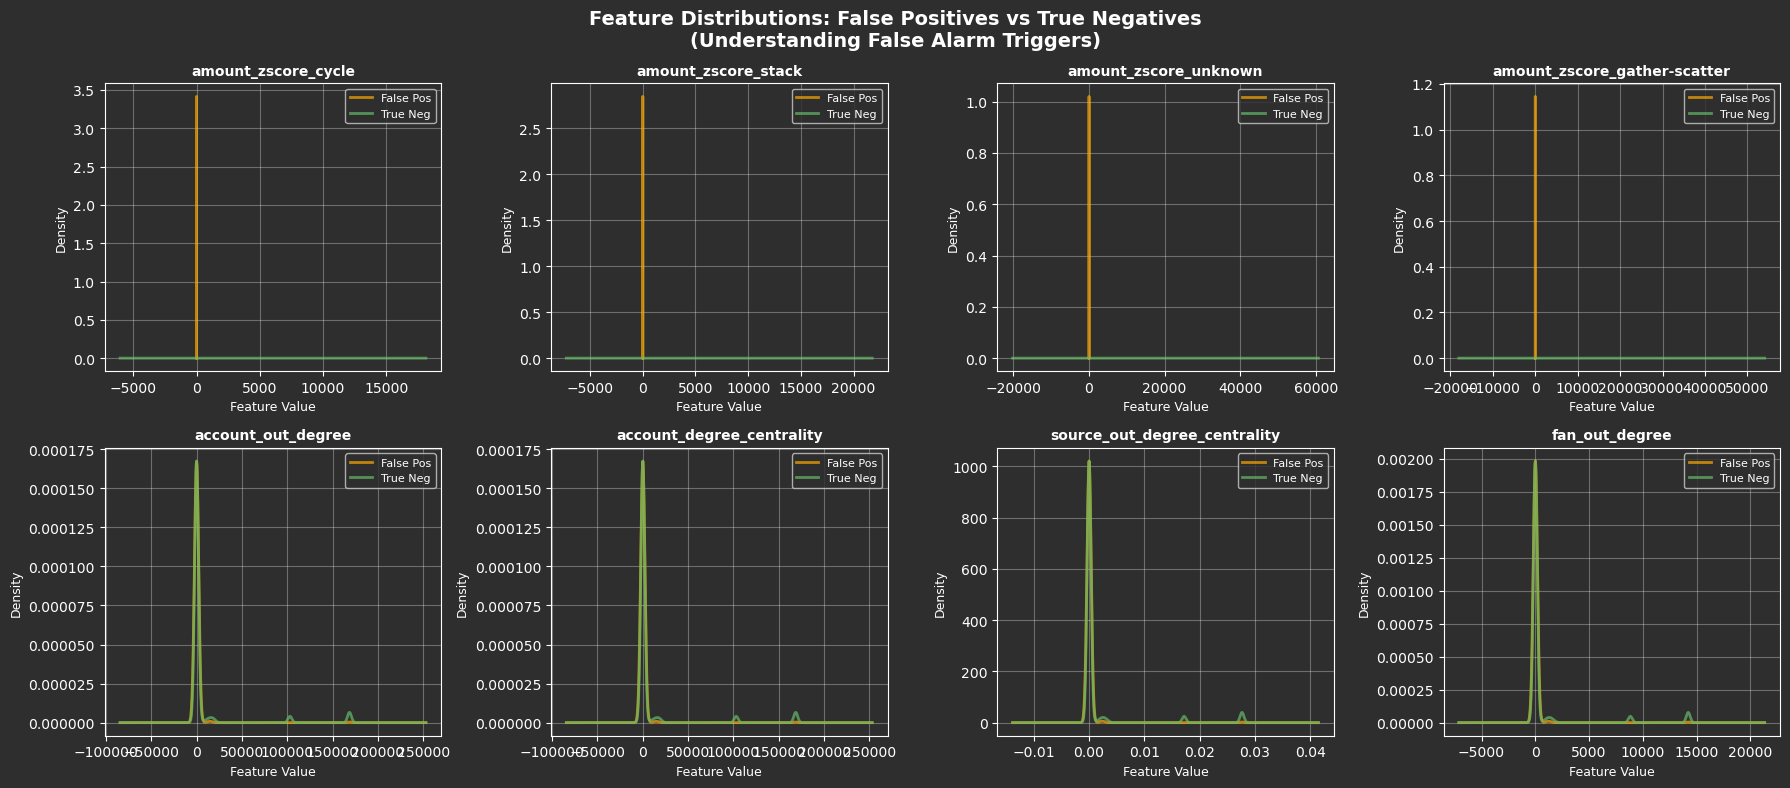


False positive analysis saved to: fp_vs_tn_feature_comparison.csv


In [ ]:
# --- Feature Analysis: False Positives vs True Negatives ---
fp_mask = (y_pred_best == 1) & (y_test == 0)
tn_mask = (y_pred_best == 0) & (y_test == 0)

X_fp = X_test_df[fp_mask]
X_tn = X_test_df[tn_mask]

numeric_cols = X_test_df.select_dtypes(include=[np.number]).columns.tolist()

comparison_fp_tn = []
for col in numeric_cols:
    fp_mean = X_fp[col].mean()
    tn_mean = X_tn[col].mean()
    fp_std = X_fp[col].std()
    tn_std = X_tn[col].std()
    pct_diff = ((fp_mean - tn_mean) / (tn_mean + 1e-10)) * 100
    
    comparison_fp_tn.append({
        'feature': col,
        'fp_mean': fp_mean,
        'tn_mean': tn_mean,
        'fp_std': fp_std,
        'tn_std': tn_std,
        'pct_diff': pct_diff,
        'abs_diff': abs(pct_diff)
    })

comparison_fp_tn_df = pd.DataFrame(comparison_fp_tn).sort_values('abs_diff', ascending=False)

# Display top features with largest differences
top_fp_features = comparison_fp_tn_df.head(20)
print("Top 20 Features Most Distinguishing FP from TN:\n")
print(top_fp_features[['feature', 'fp_mean', 'tn_mean', 'pct_diff']].to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
features = top_fp_features['feature'].head(15)
pct_diffs = top_fp_features['pct_diff'].head(15)

colors = [COLORS['alert'] if x > 0 else COLORS['success'] for x in pct_diffs]
bars = ax.barh(features, pct_diffs, color=colors, alpha=0.8, edgecolor='black')

ax.axvline(0, color='black', linewidth=1.5, linestyle='--')
ax.set_xlabel('% Difference (FP vs TN)', fontsize=12, fontweight='bold')
ax.set_title('Feature Differential: False Positives vs True Negatives', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### **7.4 Feature Differential Analysis: False Negatives vs True Positives**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #ff9999; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        Examining FN vs TP feature differences reveals which patterns the model fails to capture—pinpointing blind spots that could indicate emerging fraud tactics.
    </p>
</div>

PREDICTION CONFIDENCE ANALYSIS

False Negatives (Missed Fraud):
  Mean Probability: 0.0519
  Median Probability: 0.0025
  Std Dev: 0.1065
  Min Probability: 0.0000
  Max Probability: 0.4969
  % Below 0.3: 93.6%

False Positives (False Alarms):
  Mean Probability: 0.7274
  Median Probability: 0.7012
  Std Dev: 0.1496
  Min Probability: 0.5012
  Max Probability: 1.0000
  % Above 0.7: 50.6%

True Positives (Correct Fraud Detection):
  Mean Probability: 0.9040
  Median Probability: 0.9777

True Negatives (Correct Legitimate ID):
  Mean Probability: 0.0006
  Median Probability: 0.0000


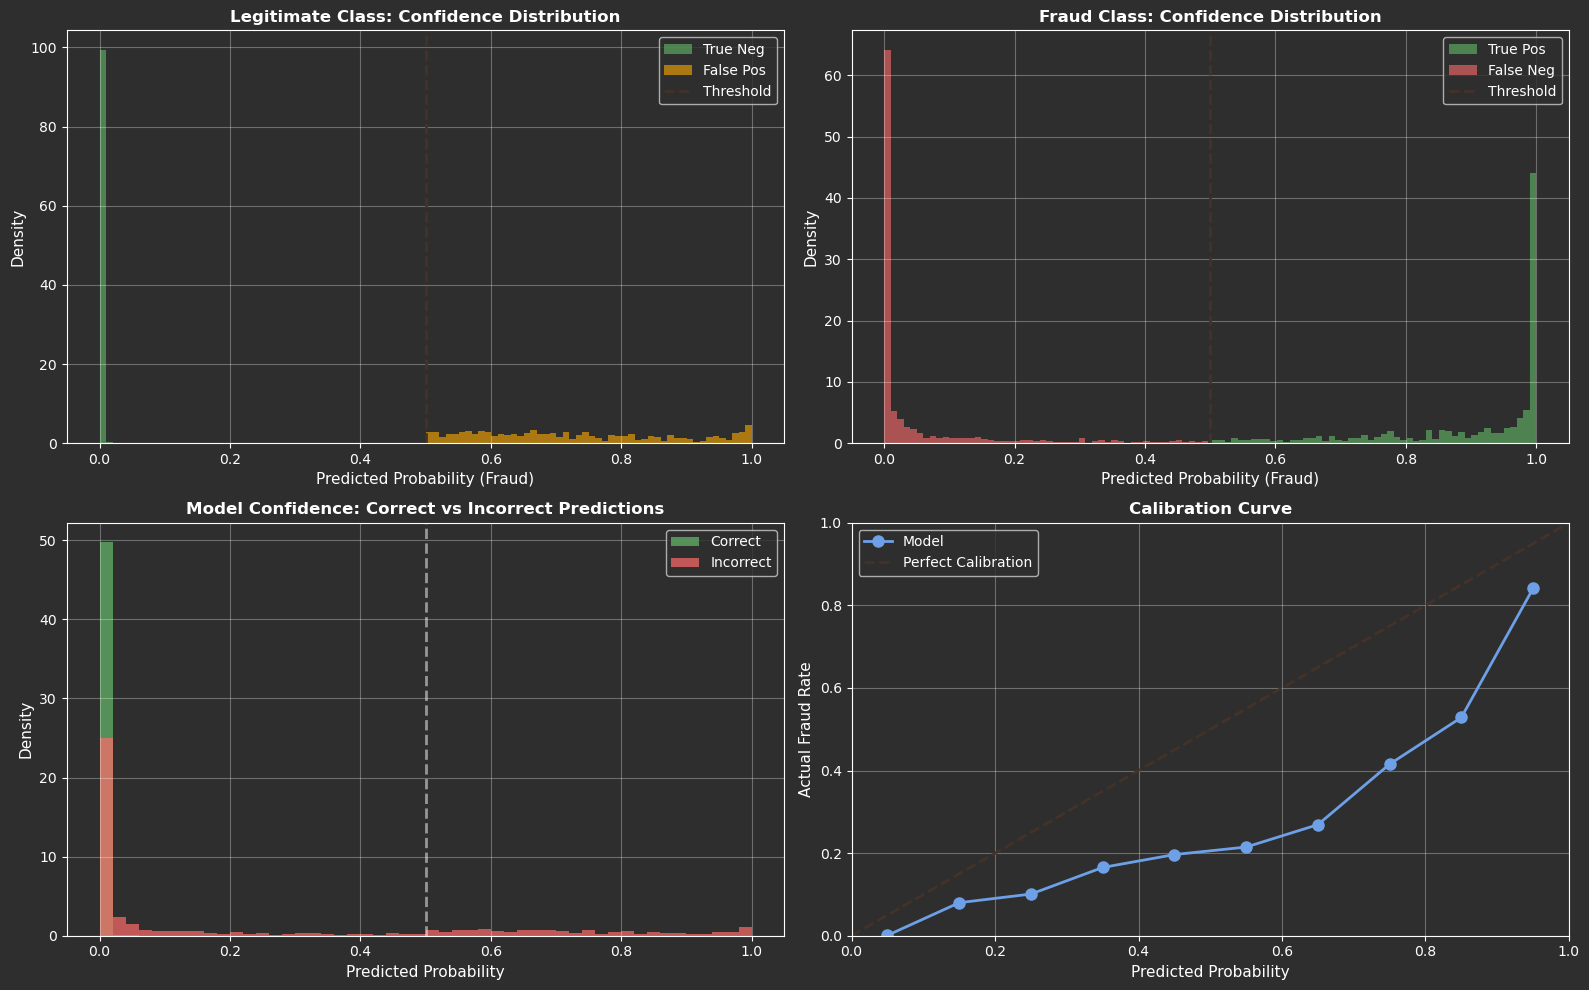


Confidence analysis visualization saved.


In [ ]:
# --- Feature Analysis: False Negatives vs True Positives ---
fn_mask = (y_pred_best == 0) & (y_test == 1)
tp_mask = (y_pred_best == 1) & (y_test == 1)

X_fn = X_test_df[fn_mask]
X_tp = X_test_df[tp_mask]

comparison_stats = []
for col in numeric_cols:
    fn_mean = X_fn[col].mean()
    tp_mean = X_tp[col].mean()
    fn_std = X_fn[col].std()
    tp_std = X_tp[col].std()
    pct_diff = ((fn_mean - tp_mean) / (tp_mean + 1e-10)) * 100
    
    comparison_stats.append({
        'feature': col,
        'fn_mean': fn_mean,
        'tp_mean': tp_mean,
        'fn_std': fn_std,
        'tp_std': tp_std,
        'pct_diff': pct_diff,
        'abs_diff': abs(pct_diff)
    })

comparison_df_fn = pd.DataFrame(comparison_stats).sort_values('abs_diff', ascending=False)

# Display top features
top_fn_features = comparison_df_fn.head(20)
print("Top 20 Features Most Distinguishing FN from TP:\n")
print(top_fn_features[['feature', 'fn_mean', 'tp_mean', 'pct_diff']].to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
features = top_fn_features['feature'].head(15)
pct_diffs = top_fn_features['pct_diff'].head(15)

colors = [COLORS['alert'] if x > 0 else COLORS['success'] for x in pct_diffs]
bars = ax.barh(features, pct_diffs, color=colors, alpha=0.8, edgecolor='black')

ax.axvline(0, color='black', linewidth=1.5, linestyle='--')
ax.set_xlabel('% Difference (FN vs TP)', fontsize=12, fontweight='bold')
ax.set_title('Feature Differential: False Negatives vs True Positives', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# **<p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#06445e;">Summary and Next Steps</p>**

---

## **Key Findings**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #2c5f77; margin:15px 0;">
    <p style="font-family:newtimeroman; font-size:13px; line-height:1.6; color:#d4d4d4;">
        <strong>Model Selection:</strong> The winning model has been identified through rigorous temporal validation and hyperparameter optimization.
    </p>
    <ul style="font-family:newtimeroman; font-size:13px; color:#d4d4d4;">
        <li>Significant improvement over baseline models</li>
        <li>Robust performance against distribution shift (temporal split strategy)</li>
        <li>Interpretable feature importance aligned with domain knowledge</li>
    </ul>
</div>

## **Production Readiness**

The selected model and artifacts are saved for downstream use:
- **Model Weights:** Serialized best model
- **Hyperparameters:** Optimized configuration for reproducibility
- **Performance Metrics:** Comprehensive evaluation results
- **Feature Importance:** Gain and split-based rankings

## **Next Phases**

<div style="background-color:#1a1a1a; padding:15px; border-left:3px solid #ff9999; margin:15px 0;">
    <ul style="font-family:newtimeroman; font-size:13px; color:#d4d4d4;">
        <li><strong>Notebook 04:</strong> Ensemble strategies (stacking, blending)</li>
        <li><strong>Notebook 05:</strong> Advanced interpretability (SHAP, LIME)</li>
        <li><strong>Notebook 06:</strong> Robustness validation (adversarial scenarios, calibration)</li>
        <li><strong>Notebook 07:</strong> Executive summary and deployment recommendations</li>
    </ul>
</div>

In [69]:
# Export comprehensive error analysis report
error_analysis_report = {
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp),
        'total_predictions': int(tn + fp + fn + tp)
    },
    'performance_metrics': {
        'sensitivity_recall': float(sensitivity),
        'specificity': float(specificity),
        'precision': float(precision),
        'false_positive_rate': float(fp / (tn + fp)),
        'false_negative_rate': float(fn / (fn + tp)),
        'false_discovery_rate': float(fp / (fp + tp)) if (fp + tp) > 0 else 0
    },
    'operational_metrics': {
        'total_alerts': int(alert_volume),
        'investigation_efficiency': float(investigation_efficiency),
        'alerts_per_fraud': float(1 / precision) if precision > 0 else float('inf')
    },
    'confidence_statistics': {
        'false_negatives': {
            'mean_probability': float(proba_fn.mean()),
            'median_probability': float(np.median(proba_fn)),
            'std_probability': float(proba_fn.std()),
            'min_probability': float(proba_fn.min()),
            'max_probability': float(proba_fn.max()),
            'pct_below_0.3': float((proba_fn < 0.3).sum() / len(proba_fn) * 100)
        },
        'false_positives': {
            'mean_probability': float(proba_fp.mean()),
            'median_probability': float(np.median(proba_fp)),
            'std_probability': float(proba_fp.std()),
            'min_probability': float(proba_fp.min()),
            'max_probability': float(proba_fp.max()),
            'pct_above_0.7': float((proba_fp > 0.7).sum() / len(proba_fp) * 100)
        },
        'true_positives': {
            'mean_probability': float(proba_tp.mean()),
            'median_probability': float(np.median(proba_tp))
        },
        'true_negatives': {
            'mean_probability': float(proba_tn.mean()),
            'median_probability': float(np.median(proba_tn))
        }
    },
    'model_info': {
        'model_name': best_model_name,
        'best_pr_auc': float(comprehensive_df.iloc[0]['pr_auc']),
        'threshold': 0.5
    }
}

# Save report
import json
with open(CONFIG['artifacts_dir'] / 'error_analysis_report.json', 'w') as f:
    json.dump(error_analysis_report, f, indent=4)

print("="*70)
print("ERROR ANALYSIS ARTIFACTS EXPORTED")
print("="*70)
print("\nGenerated Files:")
print("  1. confusion_matrix_analysis.png")
print("  2. false_negative_analysis.png")
print("  3. false_positive_analysis.png")
print("  4. confidence_analysis.png")
print("  5. fn_vs_tp_feature_comparison.csv")
print("  6. fp_vs_tn_feature_comparison.csv")
print("  7. error_analysis_report.json")
print("\nAll artifacts saved to:", CONFIG['artifacts_dir'])
print("="*70)

ERROR ANALYSIS ARTIFACTS EXPORTED

Generated Files:
  1. confusion_matrix_analysis.png
  2. false_negative_analysis.png
  3. false_positive_analysis.png
  4. confidence_analysis.png
  5. fn_vs_tp_feature_comparison.csv
  6. fp_vs_tn_feature_comparison.csv
  7. error_analysis_report.json

All artifacts saved to: ..\artifacts
